idea -> 

murmur 

학습 라벨
murmur 0 0 1 
unknown 0 1 0
absent 1 0 0
murmur 다른거 0.5 0.5

합칠 때: 
murmur 가 가장 높은 확률인 벡터 뽑기
murmur 확률 과 0, 0.5, 1 과의 거리의 역수를 합이 1이 되게 표준화시켜 점수만들기

학습라벨
- normal 1 0
- abnormal 
present 0.1 0.9
unknown 0.15 0.85
absent 0.2 0.8
합칠 때: 평균


    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']


In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math


In [2]:
import sys
#sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
#sys.path.insert(0,'/home/ikwak2/hmd/iy_classifier')
sys.path.insert(0,'utils')


In [3]:
from helper_code import *
from get_feature import *

In [4]:
root_dir = 'physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [5]:
import tensorflow as tf

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Jul  6 10:32:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   37C    P0    39W / 300W |      2MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [7]:
df = pd.read_csv(training_data_file)
df[:10]

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.90,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.10,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.10,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.90,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.20,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
6,23625,AV+PV+TV+MV,Child,Female,92.0,14.00,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,50379.0
7,24160,AV+PV+TV+MV,Child,Female,98.0,17.66,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
8,29045,AV+PV+TV+MV,Child,Female,88.0,12.50,False,Present,AV+MV+PV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
9,29378,AV+MV,Child,Female,82.0,10.70,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


In [8]:
data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/ubuntu/data/hmd/murmur/train'
test_folder = '/home/ubuntu/data/hmd/murmur/test'
model_folder = 'tmp_model3'

In [9]:
data_folder

'physionet.org/files/circor-heart-sound/1.0.3/training_data'

In [10]:
patient_files = find_patient_files(data_folder)
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

num_patient_files = len(patient_files)


In [11]:
!cat /home/ubuntu/data/hmd/murmur/train/46778.txt

46778 1 4000
MV 46778_MV.hea 46778_MV.wav 46778_MV.tsv
#Age: Adolescent
#Sex: Female
#Height: 150.0
#Weight: 54.7
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: Early-diastolic
#Diastolic murmur shape: Decrescendo
#Diastolic murmur grading: I/IV
#Diastolic murmur pitch: Low
#Diastolic murmur quality: Blowing
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49754


In [12]:
!cat /home/ubuntu/data/hmd/murmur/train/46532.txt

46532 1 4000
AV 46532_AV.hea 46532_AV.wav 46532_AV.tsv
#Age: Child
#Sex: Female
#Height: 70.0
#Weight: 9.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan


In [13]:
len(patient_files)

942

In [14]:
os.makedirs(model_folder, exist_ok=True)

murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Abnormal', 'Normal']
num_mm_classes = len(murmur_classes)
num_o_classes = len(outcome_classes)

In [15]:
def get_murmur_loc(data):
    murmur_loc = 0
    for l in data.split('\n'):
        if l.startswith('#Murmur locations: '):
            try:
                murmur_loc = l.split(': ')[1]
#                murmur_loc = murmur_loc.split('+')
            except:
                pass
    return murmur_loc

In [16]:
def get_features_3lb(patient_files_trn) :
    features = dict()
    features['id'] = []
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
#    labels = []
    mm_labels = []
    out_labels = []

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in range(num_patient_files):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]
            filename = os.path.join(data_folder, recording_file)

            # Extract id
            id1 = recording_file.split('_')[0]
            features['id'].append(id1)

            # Extract melspec
            mel1 = feature_extract_melspec(filename)[0]
            features['mel1'].append(mel1)

            # Extract age_group
            age_group = get_age(current_patient_data)
            current_age_group = np.zeros(6, dtype=int)
            if age_group in age_classes:
                j = age_classes.index(age_group)
                current_age_group[j] = 1
            else :
                current_age_group[5] = 1
            features['age'].append(current_age_group)

            # Extract sex
            sex = get_sex(current_patient_data)
            sex_features = np.zeros(2, dtype=int)
            if compare_strings(sex, 'Female'):
                sex_features[0] = 1
            elif compare_strings(sex, 'Male'):
                sex_features[1] = 1
            features['sex'].append(sex_features)

            # Extract height and weight.
            height = get_height(current_patient_data)
            weight = get_weight(current_patient_data)
            ## simple impute
            if math.isnan(height) :
                height = 110.846
            if math.isnan(weight) :
                weight = 23.767
                
            features['hw'].append(np.array([height, weight]))

            # Extract pregnancy
            is_pregnant = get_pregnancy_status(current_patient_data)
            features['preg'].append(is_pregnant)

            # Extract location
            locations = entries[0]
            num_recording_locations = len(recording_locations)
            loc_features = np.zeros(num_recording_locations)
            if locations in recording_locations:
                j = recording_locations.index(locations)
                loc_features[j] = 1
            features['loc'].append(loc_features)

            # Extract labels 
            mm_label = get_murmur(current_patient_data)
            out_label = get_outcome(current_patient_data)
            current_mm_labels = np.zeros(2)
            current_out_labels = np.zeros(2)
            if mm_label == 'Absent' :
                current_mm_labels = np.array([0, 0, 1])
            elif mm_label == 'unknown' :
                current_mm_labels = np.array([0, 1, 0])
            else :
                mm_loc = get_murmur_loc(current_patient_data)
                if mm_loc == 'nan' :
                    current_mm_labels = np.array([0.9, 0.05, 0.05])
                else :
                    mm_loc = mm_loc.split('+')
                    if locations in mm_loc :
                        current_mm_labels = np.array([1, 0, 0])
                    else :
                        current_mm_labels = np.array([0.7, 0.2, 0.1])

            if out_label == 'Normal' :
                current_out_labels = np.array([0, 1])
            else :
                current_out_labels = np.array([1, 0])
#                if mm_label == 'Absent' :
#                    current_out_labels = np.array([0.8, 0.2])
#                elif mm_label == 'unknown' :
#                    current_out_labels = np.array([0.85, 0.15])
#                else :
#                    current_out_labels = np.array([1, 0])
                
            mm_labels.append(current_mm_labels)
            out_labels.append(current_out_labels)

    M, N = features['mel1'][i].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)
    
    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
    
    mm_labels = np.array(mm_labels)
    out_labels = np.array(out_labels)
    return features, mm_labels, out_labels

In [17]:

def get_features_wo_labels(patient_files_trn) :
    features = dict()
    features['id'] = []
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
    labels = []

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in range(num_patient_files):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]
            filename = os.path.join(data_folder, recording_file)

            # Extract id
            id1 = recording_file.split('_')[0]
            features['id'].append(id1)

            # Extract melspec
            mel1 = feature_extract_melspec(filename)[0]
            features['mel1'].append(mel1)

            # Extract age_group
            age_group = get_age(current_patient_data)
            current_age_group = np.zeros(6, dtype=int)
            if age_group in age_classes:
                j = age_classes.index(age_group)
                current_age_group[j] = 1
            else :
                current_age_group[5] = 1
            features['age'].append(current_age_group)

            # Extract sex
            sex = get_sex(current_patient_data)
            sex_features = np.zeros(2, dtype=int)
            if compare_strings(sex, 'Female'):
                sex_features[0] = 1
            elif compare_strings(sex, 'Male'):
                sex_features[1] = 1
            features['sex'].append(sex_features)

            # Extract height and weight.
            height = get_height(current_patient_data)
            weight = get_weight(current_patient_data)
            if height == 'nan' :
                height = 110.846
            if weight == 'nan' :
                weight = 23.767
            features['hw'].append(np.array([height, weight]))

            # Extract pregnancy
            is_pregnant = get_pregnancy_status(current_patient_data)
            features['preg'].append(is_pregnant)

            # Extract location
            locations = entries[0]
            num_recording_locations = len(recording_locations)
            loc_features = np.zeros(num_recording_locations)
            if locations in recording_locations:
                j = recording_locations.index(locations)
                loc_features[j] = 1
            features['loc'].append(loc_features)
        
    M, N = features['mel1'][i].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
    
    return features

In [18]:
features_trn = get_features_3lb(patient_files_trn)

In [19]:
features_test = get_features_3lb(patient_files_test)

In [20]:
features_trn[0]['hw']

array([[ 98.   ,  15.9  ],
       [ 98.   ,  15.9  ],
       [ 98.   ,  15.9  ],
       ...,
       [110.846,  23.767],
       [110.846,  23.767],
       [110.846,  23.767]])

In [21]:
# Load recordings. wav data recording
def load_recordings(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        recording, frequency = load_wav_file(filename)
        recordings.append(recording)
        frequencies.append(frequency)

    if get_frequencies:
        return recordings, frequencies
    else:
        return recordings

In [22]:
import tensorflow as tf

In [23]:
from tensorflow.keras.utils import to_categorical

## Modeling

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
features_trn[0]['mel1'][0].shape

(100, 313, 1)

## A toy model

In [32]:
def get_toy(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = concat2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [33]:
def get_toy2(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = [res1, res2] )
    
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [35]:
model = get_toy2((100, 313, 1))

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 49, 155, 16)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 45, 151, 32)  12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [37]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], [features_trn[1],features_trn[2]],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             [features_test[1], features_test[2]]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 5s 18ms/step - loss: 10.6253 - dense_14_loss: 6.6848 - dense_15_loss: 3.9405 - dense_14_accuracy: 0.4808 - dense_15_accuracy: 0.5200 - val_loss: 1.7447 - val_dense_14_loss: 1.0513 - val_dense_15_loss: 0.6934 - val_dense_14_accuracy: 0.7448 - val_dense_15_accuracy: 0.5008
Epoch 2/30
80/80 [==============================] - 1s 10ms/step - loss: 1.7285 - dense_14_loss: 1.0359 - dense_15_loss: 0.6925 - dense_14_accuracy: 0.7629 - dense_15_accuracy: 0.5195 - val_loss: 1.6919 - val_dense_14_loss: 0.9984 - val_dense_15_loss: 0.6934 - val_dense_14_accuracy: 0.7448 - val_dense_15_accuracy: 0.5008
Epoch 3/30
80/80 [==============================] - 1s 10ms/step - loss: 1.6763 - dense_14_loss: 0.9841 - dense_15_loss: 0.6922 - dense_14_accuracy: 0.7526 - dense_15_accuracy: 0.5238 - val_loss: 1.6444 - val_dense_14_loss: 0.9509 - val_dense_15_loss: 0.6935 - val_dense_14_accuracy: 0.7448 - val_dense_15_accuracy: 0.5008
Epoch 4/30
80/80 [============

80/80 [==============================] - 1s 10ms/step - loss: 1.3048 - dense_14_loss: 0.6136 - dense_15_loss: 0.6912 - dense_14_accuracy: 0.7691 - dense_15_accuracy: 0.5357 - val_loss: 1.3364 - val_dense_14_loss: 0.6424 - val_dense_15_loss: 0.6940 - val_dense_14_accuracy: 0.7448 - val_dense_15_accuracy: 0.5008
Epoch 27/30
80/80 [==============================] - 1s 10ms/step - loss: 1.3034 - dense_14_loss: 0.6117 - dense_15_loss: 0.6918 - dense_14_accuracy: 0.7681 - dense_15_accuracy: 0.5273 - val_loss: 1.3337 - val_dense_14_loss: 0.6397 - val_dense_15_loss: 0.6939 - val_dense_14_accuracy: 0.7448 - val_dense_15_accuracy: 0.5008
Epoch 28/30
80/80 [==============================] - 1s 10ms/step - loss: 1.3038 - dense_14_loss: 0.6111 - dense_15_loss: 0.6926 - dense_14_accuracy: 0.7663 - dense_15_accuracy: 0.5167 - val_loss: 1.3311 - val_dense_14_loss: 0.6373 - val_dense_15_loss: 0.6939 - val_dense_14_accuracy: 0.7448 - val_dense_15_accuracy: 0.5008
Epoch 29/30
80/80 [=====================

##  outcome 따로 학습시켜보기


In [38]:
def get_toy3_1(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [39]:
model = get_toy3_1((100, 313, 1))

In [40]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[1],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 2s 13ms/step - loss: 1.3666 - accuracy: 0.6837 - val_loss: 0.6039 - val_accuracy: 0.7448
Epoch 2/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6142 - accuracy: 0.7497 - val_loss: 0.5824 - val_accuracy: 0.7528
Epoch 3/30
80/80 [==============================] - 1s 9ms/step - loss: 0.5816 - accuracy: 0.7632 - val_loss: 0.5553 - val_accuracy: 0.7797
Epoch 4/30
80/80 [==============================] - 1s 9ms/step - loss: 0.5139 - accuracy: 0.8063 - val_loss: 0.5193 - val_accuracy: 0.7940
Epoch 5/30
80/80 [==============================] - 1s 9ms/step - loss: 0.4898 - accuracy: 0.8183 - val_loss: 0.5948 - val_accuracy: 0.7876
Epoch 6/30
80/80 [==============================] - 1s 9ms/step - loss: 0.4819 - accuracy: 0.8323 - val_loss: 0.5007 - val_accuracy: 0.8019
Epoch 7/30
80/80 [==============================] - 1s 9ms/step - loss: 0.4472 - accuracy: 0.8387 - val_loss: 0.5524 - val_accuracy: 0.7924
Epoch 8/30
80/80 [=

In [41]:
def get_toy3_2(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [42]:
model = get_toy3_2((100, 313, 1))

In [43]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[2],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 2s 13ms/step - loss: 0.8696 - accuracy: 0.5002 - val_loss: 0.6675 - val_accuracy: 0.5721
Epoch 2/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6939 - accuracy: 0.5108 - val_loss: 0.6672 - val_accuracy: 0.5737
Epoch 3/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6720 - accuracy: 0.5824 - val_loss: 0.6873 - val_accuracy: 0.5277
Epoch 4/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6739 - accuracy: 0.5793 - val_loss: 0.6509 - val_accuracy: 0.6149
Epoch 5/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6667 - accuracy: 0.5895 - val_loss: 0.6527 - val_accuracy: 0.5832
Epoch 6/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6746 - accuracy: 0.5690 - val_loss: 0.6758 - val_accuracy: 0.5864
Epoch 7/30
80/80 [==============================] - 1s 9ms/step - loss: 0.6586 - accuracy: 0.6114 - val_loss: 0.6547 - val_accuracy: 0.6244
Epoch 8/30
80/80 [=

더 좋음


## 외부 피쳐 안써보기

In [44]:
def get_toy4_1(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

#    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
#    d1 = layers.Dense(2, activation = 'relu')(concat1)
#    concat2 = layers.Concatenate()([d1, mel2])
#    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(mel2)
    res2 = layers.Dense(2, activation = "softmax")(mel2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

def get_toy4_2(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

#    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
#    d1 = layers.Dense(2, activation = 'relu')(concat1)
#    concat2 = layers.Concatenate()([d1, mel2])
#    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(mel2)
    res2 = layers.Dense(2, activation = "softmax")(mel2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [45]:
model = get_toy4_1((100, 313, 1))

In [46]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[1],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 1s 12ms/step - loss: 1.0170 - accuracy: 0.7096 - val_loss: 0.6113 - val_accuracy: 0.7448
Epoch 2/30
80/80 [==============================] - 1s 8ms/step - loss: 0.5484 - accuracy: 0.7778 - val_loss: 0.7189 - val_accuracy: 0.7544
Epoch 3/30
80/80 [==============================] - 1s 8ms/step - loss: 0.5682 - accuracy: 0.7857 - val_loss: 0.4926 - val_accuracy: 0.8098
Epoch 4/30
80/80 [==============================] - 1s 8ms/step - loss: 0.5000 - accuracy: 0.8069 - val_loss: 0.4882 - val_accuracy: 0.8177
Epoch 5/30
80/80 [==============================] - 1s 8ms/step - loss: 0.4759 - accuracy: 0.8218 - val_loss: 0.4907 - val_accuracy: 0.8130
Epoch 6/30
80/80 [==============================] - 1s 8ms/step - loss: 0.4307 - accuracy: 0.8422 - val_loss: 0.4808 - val_accuracy: 0.8162
Epoch 7/30
80/80 [==============================] - 1s 8ms/step - loss: 0.4388 - accuracy: 0.8409 - val_loss: 0.4973 - val_accuracy: 0.8130
Epoch 8/30
80/80 [=

In [47]:
model = get_toy4_2((100, 313, 1))

In [48]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[2],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 1s 12ms/step - loss: 0.9428 - accuracy: 0.5206 - val_loss: 0.6754 - val_accuracy: 0.5848
Epoch 2/30
80/80 [==============================] - 1s 8ms/step - loss: 0.6849 - accuracy: 0.5591 - val_loss: 0.6813 - val_accuracy: 0.5642
Epoch 3/30
80/80 [==============================] - 1s 8ms/step - loss: 0.6859 - accuracy: 0.5215 - val_loss: 0.6616 - val_accuracy: 0.6006
Epoch 4/30
80/80 [==============================] - 1s 8ms/step - loss: 0.6716 - accuracy: 0.5505 - val_loss: 0.6584 - val_accuracy: 0.6355
Epoch 5/30
80/80 [==============================] - 1s 8ms/step - loss: 0.6677 - accuracy: 0.5831 - val_loss: 0.6714 - val_accuracy: 0.5943
Epoch 6/30
80/80 [==============================] - 1s 8ms/step - loss: 0.6775 - accuracy: 0.5731 - val_loss: 0.6367 - val_accuracy: 0.6117
Epoch 7/30
80/80 [==============================] - 1s 8ms/step - loss: 0.6601 - accuracy: 0.5902 - val_loss: 0.6360 - val_accuracy: 0.6149
Epoch 8/30
80/80 [=

비슷비슷한듯?

In [ ]:
features_trn[1]

In [233]:
X_trn = [features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']].copy()

In [235]:
isinstance(X_trn, list)

True

In [236]:
X_trn[0].shape

(2532, 6)

In [237]:
X_trn[1].shape

(2532, 2)

In [238]:
X_trn[2].shape

(2532, 2)

In [239]:
X_trn[3].shape

(2532,)

In [240]:
X_trn[3]

array([False, False, False, ...,  True,  True,  True])

In [241]:
X_trn[3].shape

(2532,)

In [242]:
X_trn[4].shape

(2532, 5)

In [243]:
X_trn[5].shape

(2532, 100, 313, 1)

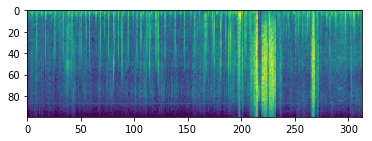

In [247]:
import matplotlib.pyplot as plt

img = X_trn[5][0].reshape(100,313)
plt.imshow(img)

In [244]:
bs = 2532 / 2
bs

1266.0

### mixup

In [245]:
alpha = .3
bs = 1266

if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, h, w, c = X_temp.shape
            l = np.random.beta(alpha, alpha, bs)
            X_l = l.reshape(bs, 1, 1, 1)
            y_l = l.reshape(bs, 1)
        elif len(X_temp.shape) == 2 :
            _, h = X_temp.shape
            l = np.random.beta(alpha, alpha, bs)
            X_l = l.reshape(bs, 1)
            y_l = l.reshape(bs, 1)
        elif len(X_temp.shape) == 1 :
            _ = X_temp.shape
            l = np.random.beta(alpha, alpha, bs)
            X_l = l.reshape(bs, )
            y_l = l.reshape(bs, 1)

        X1 = X_temp[:bs].copy()
        X2 = X_temp[bs:].copy()
        X.append(X1 * X_l + X2 * (1 - X_l))


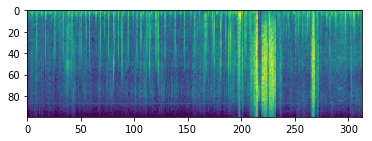

In [250]:
import matplotlib.pyplot as plt

img = X_trn[5][0].reshape(100,313)
plt.imshow(img)

### low frequency feature masking (LF)

In [251]:
if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, h, w, c = X_temp.shape
            
            if [0.5, [10,11,12]] :
                uv, lp = [0.5, [10,11,12]]
                dec1 = np.random.choice(2, size = 2*1266)
                for i in range(2*1266) :
                    loc1 = np.random.choice(lp, size = 1)[0]
                    X_temp[i,:loc1,:,:] = 0
        X1 = X_temp            
        X.append(X1)


In [252]:
X[5][0].shape

(100, 313, 1)

mixup + LF 적용된 피쳐들

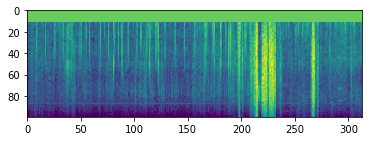

In [253]:
import matplotlib.pyplot as plt

img = X[5][0].reshape(100,313)
plt.imshow(img)

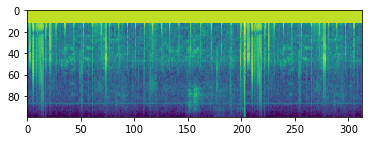

In [254]:
img = X[5][1].reshape(100,313)
plt.imshow(img)

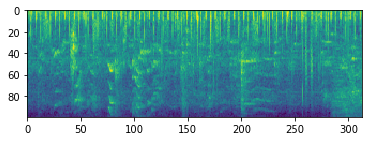

In [255]:
img = X[5][1267].reshape(100,313)
plt.imshow(img)

mixup + LF + HF 적용된 피쳐들

In [256]:
if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, h, w, c = X_temp.shape
            
            if [0.5, [80,81,82]] :
                uv, hp = [0.5, [80,81,82]]
#                dec1 = np.random.choice(2, size = 2*1266, p = uv)
                for i in range(1266) :
                    loc1 = np.random.choice(hp, size = 1)[0]
                    X_temp[i,loc1:,:,:] = 0
        X1 = X_temp            
        X.append(X1)

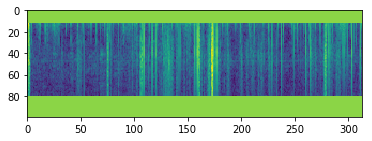

In [257]:
img = X_trn[5][100].reshape(100,313)
plt.imshow(img)

mixup + LF+HF+RF 적용된 피쳐들

In [258]:
if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, nf, w, c = X_temp.shape
            
            if [2, [10,11,12]] :
                raniter, ranf = [2, [10,11,12]]
                dec1 = np.random.choice(raniter, size = 2*1266)
                for i in range(2*1266) :
                    if dec1[i] > 0 :
                        for j in range(dec1[i]) :
                            b1 = np.random.choice(ranf, size = 1)[0]
                            loc1 = np.random.choice(nf - b1, size = 1)[0]
                            X_temp[i, loc1:(loc1 + b1 - 1), :] = 0
        X1 = X_temp            
        X.append(X1)

        if self.ranfilter2 :   ## ex ranfilter2 = [4,[10,11,12,13,14,15]]
            raniter, ranf = self.ranfilter2
            dec1 = np.random.choice(raniter, size = self.batch_size)
            for i in range(self.batch_size) :
                if dec1[i] > 0 :
                    for j in range(dec1[i]) :
                        b1 = np.random.choice(ranf, size = 1)[0]
                        loc1 = np.random.choice(nf - b1, size = 1)[0]
                        nX[i, loc1:(loc1 + b1 - 1), :] = 0

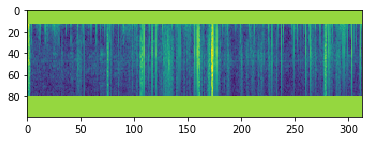

In [259]:
img = X_trn[5][100].reshape(100,313)
plt.imshow(img)

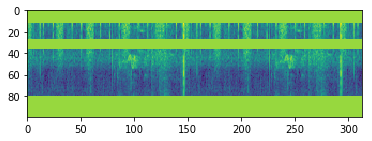

In [263]:
img = X_trn[5][13].reshape(100,313)
plt.imshow(img)

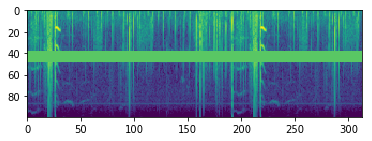

In [269]:
img = X_trn[5][1701].reshape(100,313)
plt.imshow(img)

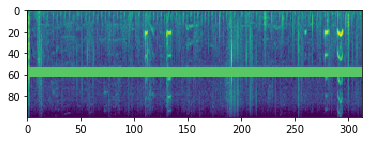

In [271]:
img = X_trn[5][1703].reshape(100,313)
plt.imshow(img)

### 첫번째 버전..

In [311]:
import os
import sys
import pandas
import numpy
import pickle
import soundfile
import pandas as pd
import numpy as np
import tensorflow
import tensorflow.keras


class Generator0():
    def __init__(self, X_train, y_train, batch_size=32, beta_param=0.2, mixup = True, lowpass = False, highpass = False, ranfilter2 = False, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = beta_param
        self.mixup = mixup
        self.shuffle = shuffle
        self.sample_num = len(y_train)
        self.datagen = datagen

        ## ffm 
        
        self.lowpass = lowpass
        self.highpass = highpass
        self.ranfilter = ranfilter2


    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        
        if isinstance(self.X_train, list):
            X = []
            for X_temp in self.X_train:
                if len(X_temp.shape) == 4: 
                    _, h, w, c = X_temp.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size, 1, 1, 1)
                    y_l = l.reshape(self.batch_size, 1)
                elif len(X_temp.shape) == 3:
                    _, h, w = self.X_train.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size, 1, 1)
                    y_l = l.reshape(self.batch_size, 1)
                elif len(X_temp.shape) == 2:
                    _, h = X_temp.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size, 1)
                    y_l = l.reshape(self.batch_size, 1)
                elif len(X_temp.shape) == 1:
                    _= X_temp.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size,)
                    y_l = l.reshape(self.batch_size, 1)
                
                X1 = X_temp[batch_ids[:self.batch_size]].copy()
                X2 = X_temp[batch_ids[self.batch_size:]].copy()
                
                if self.mixup :
                    Xn = X1 * X_l + X2 * (1 - X_l)
                else :
                    Xn = X1
                if len(X_temp.shape) == 4: 
                    _, h, w, c = X_temp.shape
                    if self.lowpass :
                        uv, lp = self.lowpass
                        dec1 = np.random.choice(2, size = self.batch_size)
                        for i in range(self.batch_size) :
                            if dec1[i] == 1 :
                                loc1 = np.random.choice(lp, size = 1)[0]
                                Xn[i,:loc1,:,:] = 0
                    if self.highpass :
                        uv, hp = self.highpass
                        dec1 = np.random.choice(2, size = self.batch_size)
                        for i in range(self.batch_size) :
                            if dec1[i] == 1 :
                                loc1 = np.random.choice(hp, size = 1)[0]
                                Xn[i,loc1:,:,:] = 0
                    if self.ranfilter :                
                        raniter, ranf = self.ranfilter
                        dec1 = np.random.choice(raniter, size = self.batch_size)
                        for i in range(self.batch_size) :
                            if dec1[i] > 0 :
                                for j in range(dec1[i]) :
                                    b1 = np.random.choice(ranf, size = 1)[0]
                                    loc1 = np.random.choice(h - b1, size = 1)[0]
                                    Xn[i, loc1:(loc1 + b1 - 1), :] = 0
                X.append(Xn)
        else:
            if len(self.X_train.shape) == 4: 
                _, h, w, c = self.X_train.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size, 1, 1, 1)
                y_l = l.reshape(self.batch_size, 1)
            elif len(self.X_train.shape) == 3:
                _, h, w = self.X_train.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size, 1, 1)
                y_l = l.reshape(self.batch_size, 1)
            elif len(X_temp.shape) == 2:
                _, h = X_temp.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size, 1)
                y_l = l.reshape(self.batch_size, 1)
            elif len(X_temp.shape) == 1:
                _= X_temp.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size,)
                y_l = l.reshape(self.batch_size, 1)

            X1 = self.X_train[batch_ids[:self.batch_size]].copy()
            X2 = self.X_train[batch_ids[self.batch_size:]].copy()
            if self.mixup :
                Xn = X1 * X_l + X2 * (1 - X_l)
            else :
                Xn = X1

            if len(self.X_train.shape) == 4: 
                _, h, w, c = X_temp.shape
                if self.lowpass :
                    uv, lp = self.lowpass
                    dec1 = np.random.choice(2, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] == 1 :
                            loc1 = np.random.choice(lp, size = 1)[0]
                            Xn[i,:loc1,:,:] = 0
                if self.highpass :
                    uv, hp = self.highpass
                    dec1 = np.random.choice(2, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] == 1 :
                            loc1 = np.random.choice(hp, size = 1)[0]
                            Xn[i,loc1:,:,:] = 0
                if self.ranfilter :                
                    raniter, ranf = self.ranfilter
                    dec1 = np.random.choice(raniter, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] > 0 :
                            for j in range(dec1[i]) :
                                b1 = np.random.choice(ranf, size = 1)[0]
                                loc1 = np.random.choice(h - b1, size = 1)[0]
                                Xn[i, loc1:(loc1 + b1 - 1), :] = 0
            X.append(Xn)

                
        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]].copy()
                y2 = y_train_[batch_ids[self.batch_size:]].copy()
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]].copy()
            y2 = self.y_train[batch_ids[self.batch_size:]].copy()
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [299]:
features_test[1].shape

(631, 3)

In [300]:
model = get_toy3_1((100, 313, 1))
model.summary()

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d_276 (Conv2D)             (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_276 (MaxPooling2D (None, 49, 155, 16)  0           conv2d_276[0][0]                 
__________________________________________________________________________________________________
conv2d_277 (Conv2D)             (None, 45, 151, 32)  12832       max_pooling2d_276[0][0]          
___________________________________________________________________________________________

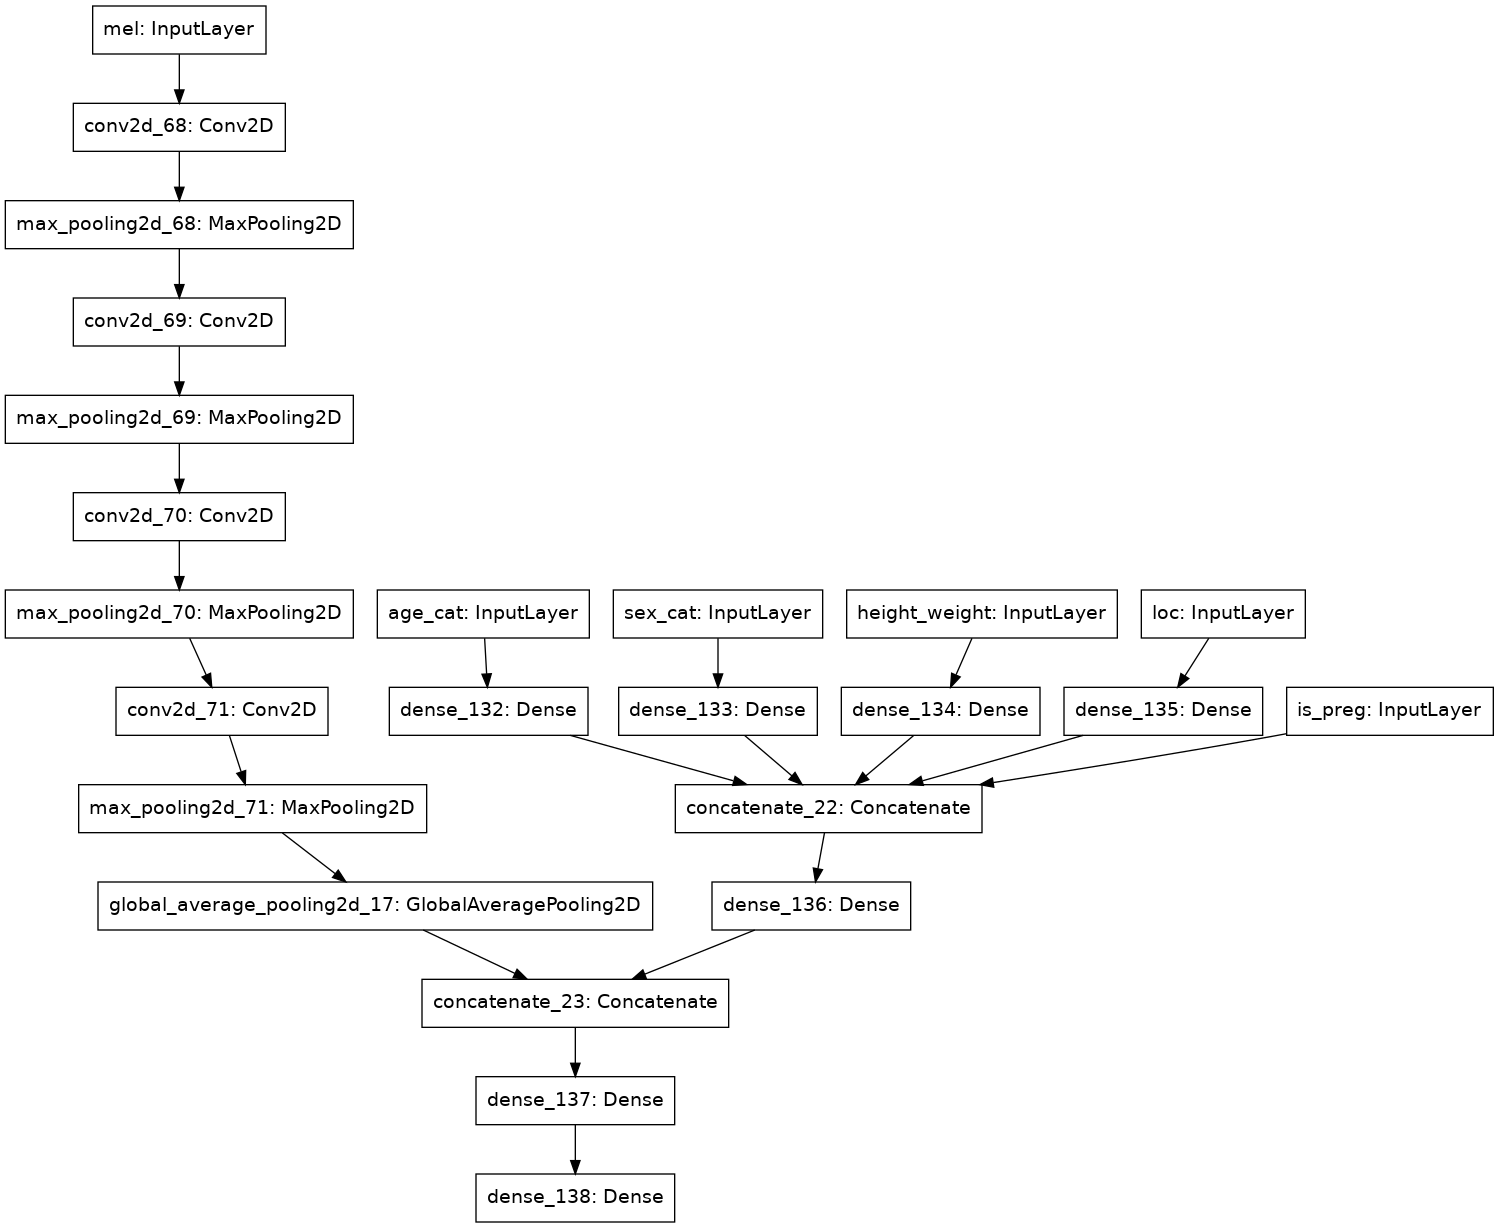

In [92]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [301]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [302]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end



In [321]:
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True
#          'lowpass': [11,12,13,14,15,16,17,18],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
                     'mixup': False
          #'device': device
}
TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

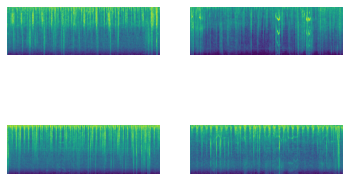

In [322]:
import matplotlib.pyplot as plt
x, y = next(TrainDGen_1)
cols, rows = 2, 2
img_num = cols * rows

imgs = x[5].reshape(64,100,313)

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

In [323]:
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
          'lowpass': [0.5, [11,12,13,14,15,16,17,18]],
          #'highpass': [78,79,80,81,82,83,84,85],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
                     'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

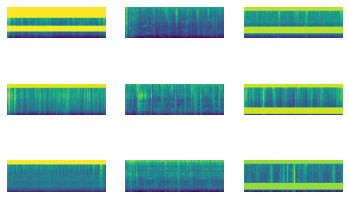

In [324]:
import matplotlib.pyplot as plt
x, y = next(TrainDGen_1)
cols, rows = 3, 3
img_num = cols * rows

imgs = x[5].reshape(64,100,313)

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

In [296]:
imgs.shape

(64, 100, 313)

In [325]:
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True
#          'lowpass': [11,12,13,14,15,16,17,18],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
                     'mixup': False
          #'device': device
}
TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

In [320]:
#mc = ModelCheckpoint('checkpoint.h5', monitor='val_categorical_accuracy',
#                          verbose=True, save_best_only=True,
#                          mode ='auto', period =1)
    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/50
40/40 [==============================] - 3s 50ms/step - loss: 1.1227 - accuracy: 0.6938 - val_loss: 0.6019 - val_accuracy: 0.7544
Epoch 2/50
40/40 [==============================] - 2s 40ms/step - loss: 0.5970 - accuracy: 0.7632 - val_loss: 0.5872 - val_accuracy: 0.7544
Epoch 3/50
40/40 [==============================] - 2s 41ms/step - loss: 0.5858 - accuracy: 0.7740 - val_loss: 0.5816 - val_accuracy: 0.7623
Epoch 4/50
40/40 [==============================] - 2s 41ms/step - loss: 0.5765 - accuracy: 0.7796 - val_loss: 0.5802 - val_accuracy: 0.7559
Epoch 5/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5584 - accuracy: 0.7924 - val_loss: 0.5614 - val_accuracy: 0.7591
Epoch 6/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5865 - accuracy: 0.7788 - val_loss: 0.5463 - val_accuracy: 0.7892
Epoch 7/50
40/40 [==============================] - 2s 41ms/step - loss: 0.5506 - accuracy: 0.7962 - val_loss: 0.5593 - val_accuracy: 0.7750
Epoch 8/50
40

mixup 무난해보임

In [327]:
model = get_toy3_1((100, 313, 1))
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/50
40/40 [==============================] - 3s 49ms/step - loss: 4.6713 - accuracy: 0.5571 - val_loss: 0.6944 - val_accuracy: 0.7448
Epoch 2/50
40/40 [==============================] - 2s 40ms/step - loss: 0.5982 - accuracy: 0.7801 - val_loss: 0.5886 - val_accuracy: 0.7448
Epoch 3/50
40/40 [==============================] - 2s 40ms/step - loss: 0.5938 - accuracy: 0.7503 - val_loss: 0.5848 - val_accuracy: 0.7433
Epoch 4/50
40/40 [==============================] - 2s 41ms/step - loss: 0.5856 - accuracy: 0.7710 - val_loss: 0.5683 - val_accuracy: 0.7544
Epoch 5/50
40/40 [==============================] - 2s 39ms/step - loss: 0.5774 - accuracy: 0.7776 - val_loss: 0.5695 - val_accuracy: 0.7639
Epoch 6/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5541 - accuracy: 0.7862 - val_loss: 0.5738 - val_accuracy: 0.7544
Epoch 7/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5638 - accuracy: 0.7820 - val_loss: 0.6418 - val_accuracy: 0.6894
Epoch 8/50
40

LP는 그럭저럭


In [328]:
model = get_toy3_1((100, 313, 1))
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]]
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/50
40/40 [==============================] - 3s 53ms/step - loss: 1.0719 - accuracy: 0.6306 - val_loss: 0.6153 - val_accuracy: 0.7448
Epoch 2/50
40/40 [==============================] - 2s 44ms/step - loss: 0.5775 - accuracy: 0.7741 - val_loss: 0.6166 - val_accuracy: 0.7448
Epoch 3/50
40/40 [==============================] - 2s 44ms/step - loss: 0.5951 - accuracy: 0.7608 - val_loss: 0.5729 - val_accuracy: 0.7559
Epoch 4/50
40/40 [==============================] - 2s 44ms/step - loss: 0.5759 - accuracy: 0.7621 - val_loss: 0.5690 - val_accuracy: 0.7528
Epoch 5/50
40/40 [==============================] - 2s 47ms/step - loss: 0.5789 - accuracy: 0.7655 - val_loss: 0.5804 - val_accuracy: 0.7512
Epoch 6/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5545 - accuracy: 0.7907 - val_loss: 0.5439 - val_accuracy: 0.7750
Epoch 7/50
40/40 [==============================] - 2s 45ms/step - loss: 0.5710 - accuracy: 0.7749 - val_loss: 0.5152 - val_accuracy: 0.8035
Epoch 8/50
40

HP는 나쁘지 않아보임

In [329]:
model = get_toy3_1((100, 313, 1))
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/50
40/40 [==============================] - 3s 50ms/step - loss: 0.8711 - accuracy: 0.6518 - val_loss: 0.6074 - val_accuracy: 0.7448
Epoch 2/50
40/40 [==============================] - 2s 44ms/step - loss: 0.5867 - accuracy: 0.7799 - val_loss: 0.5924 - val_accuracy: 0.7448
Epoch 3/50
40/40 [==============================] - 2s 46ms/step - loss: 0.5993 - accuracy: 0.7547 - val_loss: 0.5864 - val_accuracy: 0.7464
Epoch 4/50
40/40 [==============================] - 2s 47ms/step - loss: 0.5872 - accuracy: 0.7566 - val_loss: 0.5865 - val_accuracy: 0.7448
Epoch 5/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5813 - accuracy: 0.7647 - val_loss: 0.5698 - val_accuracy: 0.7639
Epoch 6/50
40/40 [==============================] - 2s 45ms/step - loss: 0.5603 - accuracy: 0.7728 - val_loss: 0.5485 - val_accuracy: 0.7686
Epoch 7/50
40/40 [==============================] - 2s 46ms/step - loss: 0.5760 - accuracy: 0.7768 - val_loss: 0.5150 - val_accuracy: 0.7940
Epoch 8/50
40

In [331]:
model = get_toy3_1((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 3s 66ms/step - loss: 0.8062 - accuracy: 0.7290 - val_loss: 0.6036 - val_accuracy: 0.7448
Epoch 2/100
40/40 [==============================] - 2s 43ms/step - loss: 0.5833 - accuracy: 0.7705 - val_loss: 0.6083 - val_accuracy: 0.7448
Epoch 3/100
40/40 [==============================] - 2s 46ms/step - loss: 0.5789 - accuracy: 0.7801 - val_loss: 0.5912 - val_accuracy: 0.7448
Epoch 4/100
40/40 [==============================] - 2s 51ms/step - loss: 0.5789 - accuracy: 0.7732 - val_loss: 0.5893 - val_accuracy: 0.7448
Epoch 5/100
40/40 [==============================] - 2s 49ms/step - loss: 0.5881 - accuracy: 0.7667 - val_loss: 0.5821 - val_accuracy: 0.7448
Epoch 6/100
40/40 [==============================] - 2s 47ms/step - loss: 0.5445 - accuracy: 0.7891 - val_loss: 0.5899 - val_accuracy: 0.7448
Epoch 7/100
40/40 [==============================] - 2s 45ms/step - loss: 0.5753 - accuracy: 0.7645 - val_loss: 0.5703 - val_accuracy: 0.7575
Epoch 

40/40 [==============================] - 2s 43ms/step - loss: 0.4759 - accuracy: 0.8390 - val_loss: 0.3895 - val_accuracy: 0.8574
Epoch 59/100
40/40 [==============================] - 2s 44ms/step - loss: 0.4540 - accuracy: 0.8468 - val_loss: 0.3954 - val_accuracy: 0.8542
Epoch 60/100
40/40 [==============================] - 2s 42ms/step - loss: 0.4354 - accuracy: 0.8700 - val_loss: 0.3941 - val_accuracy: 0.8510
Epoch 61/100
40/40 [==============================] - 2s 41ms/step - loss: 0.4331 - accuracy: 0.8600 - val_loss: 0.3897 - val_accuracy: 0.8510
Epoch 62/100
40/40 [==============================] - 2s 42ms/step - loss: 0.4535 - accuracy: 0.8502 - val_loss: 0.3879 - val_accuracy: 0.8542
Epoch 63/100
40/40 [==============================] - 2s 43ms/step - loss: 0.4319 - accuracy: 0.8671 - val_loss: 0.3824 - val_accuracy: 0.8590
Epoch 64/100
40/40 [==============================] - 2s 43ms/step - loss: 0.4359 - accuracy: 0.8582 - val_loss: 0.3870 - val_accuracy: 0.8558
Epoch 65/100

에폭 늘리면 성능 더 좋음, 오버피팅 적음.

### 외부피쳐 안쓴버전

In [332]:
model = get_toy4_1((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 2s 51ms/step - loss: 1.1667 - accuracy: 0.6737 - val_loss: 0.5880 - val_accuracy: 0.7448
Epoch 2/100
40/40 [==============================] - 2s 44ms/step - loss: 0.5779 - accuracy: 0.7727 - val_loss: 0.5708 - val_accuracy: 0.7623
Epoch 3/100
40/40 [==============================] - 2s 46ms/step - loss: 0.5740 - accuracy: 0.7646 - val_loss: 0.5617 - val_accuracy: 0.7591
Epoch 4/100
40/40 [==============================] - 2s 47ms/step - loss: 0.5565 - accuracy: 0.7829 - val_loss: 0.5813 - val_accuracy: 0.7670
Epoch 5/100
40/40 [==============================] - 2s 47ms/step - loss: 0.6083 - accuracy: 0.7674 - val_loss: 0.5536 - val_accuracy: 0.7655
Epoch 6/100
40/40 [==============================] - 2s 46ms/step - loss: 0.5712 - accuracy: 0.7684 - val_loss: 0.5451 - val_accuracy: 0.7718
Epoch 7/100
40/40 [==============================] - 2s 43ms/step - loss: 0.5631 - accuracy: 0.7726 - val_loss: 0.5374 - val_accuracy: 0.7845
Epoch 

40/40 [==============================] - 2s 47ms/step - loss: 0.4254 - accuracy: 0.8598 - val_loss: 0.4082 - val_accuracy: 0.8510
Epoch 59/100
40/40 [==============================] - 2s 44ms/step - loss: 0.4261 - accuracy: 0.8621 - val_loss: 0.3984 - val_accuracy: 0.8447
Epoch 60/100
40/40 [==============================] - 2s 41ms/step - loss: 0.4253 - accuracy: 0.8732 - val_loss: 0.3947 - val_accuracy: 0.8494
Epoch 61/100
40/40 [==============================] - 2s 42ms/step - loss: 0.4334 - accuracy: 0.8597 - val_loss: 0.3958 - val_accuracy: 0.8558
Epoch 62/100
40/40 [==============================] - 2s 44ms/step - loss: 0.4349 - accuracy: 0.8763 - val_loss: 0.4030 - val_accuracy: 0.8526
Epoch 63/100
40/40 [==============================] - 2s 41ms/step - loss: 0.4235 - accuracy: 0.8702 - val_loss: 0.3903 - val_accuracy: 0.8463
Epoch 64/100
40/40 [==============================] - 2s 45ms/step - loss: 0.4375 - accuracy: 0.8618 - val_loss: 0.3983 - val_accuracy: 0.8542
Epoch 65/100

외부 피쳐 안쓰는게 더 좋음..

### outcome 모형도 돌려보기

In [83]:
model = get_toy4_2((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 2s 48ms/step - loss: 0.9888 - accuracy: 0.5190 - val_loss: 0.6744 - val_accuracy: 0.6101
Epoch 2/100
40/40 [==============================] - 2s 43ms/step - loss: 0.7048 - accuracy: 0.4940 - val_loss: 0.6705 - val_accuracy: 0.6371
Epoch 3/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6940 - accuracy: 0.5246 - val_loss: 0.6746 - val_accuracy: 0.5547
Epoch 4/100
40/40 [==============================] - 2s 47ms/step - loss: 0.6919 - accuracy: 0.5247 - val_loss: 0.6553 - val_accuracy: 0.6387
Epoch 5/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6799 - accuracy: 0.5796 - val_loss: 0.6490 - val_accuracy: 0.6339
Epoch 6/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6863 - accuracy: 0.5448 - val_loss: 0.6424 - val_accuracy: 0.6355
Epoch 7/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6755 - accuracy: 0.5703 - val_loss: 0.6505 - val_accuracy: 0.6117
Epoch 

40/40 [==============================] - 2s 39ms/step - loss: 0.6208 - accuracy: 0.6616 - val_loss: 0.6805 - val_accuracy: 0.5975
Epoch 59/100
40/40 [==============================] - 2s 39ms/step - loss: 0.6380 - accuracy: 0.6439 - val_loss: 0.6966 - val_accuracy: 0.6307
Epoch 60/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6273 - accuracy: 0.6452 - val_loss: 0.6874 - val_accuracy: 0.6197
Epoch 61/100
40/40 [==============================] - 2s 40ms/step - loss: 0.6267 - accuracy: 0.6531 - val_loss: 0.7140 - val_accuracy: 0.6054
Epoch 62/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6341 - accuracy: 0.6502 - val_loss: 0.6777 - val_accuracy: 0.5895
Epoch 63/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6353 - accuracy: 0.6499 - val_loss: 0.6663 - val_accuracy: 0.6038
Epoch 64/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6308 - accuracy: 0.6473 - val_loss: 0.6760 - val_accuracy: 0.6054
Epoch 65/100

오버피팅 되어가는 느낌?

### outcome 외부변수 고려 안하고 HP 로 돌러보기

In [84]:
model = get_toy4_2((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]]
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 2s 50ms/step - loss: 1.4162 - accuracy: 0.5010 - val_loss: 0.6892 - val_accuracy: 0.5135
Epoch 2/100
40/40 [==============================] - 2s 39ms/step - loss: 0.6914 - accuracy: 0.5170 - val_loss: 0.6706 - val_accuracy: 0.6307
Epoch 3/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6867 - accuracy: 0.5288 - val_loss: 0.6727 - val_accuracy: 0.5610
Epoch 4/100
40/40 [==============================] - 2s 39ms/step - loss: 0.6890 - accuracy: 0.5209 - val_loss: 0.6751 - val_accuracy: 0.5610
Epoch 5/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6821 - accuracy: 0.5451 - val_loss: 0.6482 - val_accuracy: 0.6197
Epoch 6/100
40/40 [==============================] - 1s 38ms/step - loss: 0.6828 - accuracy: 0.5571 - val_loss: 0.6412 - val_accuracy: 0.6466
Epoch 7/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6835 - accuracy: 0.5751 - val_loss: 0.6774 - val_accuracy: 0.4976
Epoch 

40/40 [==============================] - 2s 42ms/step - loss: 0.6066 - accuracy: 0.6878 - val_loss: 0.7011 - val_accuracy: 0.6054
Epoch 59/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6056 - accuracy: 0.7075 - val_loss: 0.7262 - val_accuracy: 0.6165
Epoch 60/100
40/40 [==============================] - 2s 46ms/step - loss: 0.5866 - accuracy: 0.7343 - val_loss: 0.7258 - val_accuracy: 0.6022
Epoch 61/100
40/40 [==============================] - 2s 42ms/step - loss: 0.5952 - accuracy: 0.7015 - val_loss: 0.6904 - val_accuracy: 0.6165
Epoch 62/100
40/40 [==============================] - 2s 40ms/step - loss: 0.5921 - accuracy: 0.7096 - val_loss: 0.7357 - val_accuracy: 0.6228
Epoch 63/100
40/40 [==============================] - 2s 42ms/step - loss: 0.5989 - accuracy: 0.6831 - val_loss: 0.7732 - val_accuracy: 0.5864
Epoch 64/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6041 - accuracy: 0.7053 - val_loss: 0.6949 - val_accuracy: 0.6260
Epoch 65/100

In [85]:
model = get_toy4_2((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 2s 50ms/step - loss: 1.1828 - accuracy: 0.4845 - val_loss: 0.7008 - val_accuracy: 0.4992
Epoch 2/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6952 - accuracy: 0.5023 - val_loss: 0.6783 - val_accuracy: 0.5880
Epoch 3/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6909 - accuracy: 0.5207 - val_loss: 0.6661 - val_accuracy: 0.6260
Epoch 4/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6900 - accuracy: 0.5286 - val_loss: 0.6656 - val_accuracy: 0.5784
Epoch 5/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6866 - accuracy: 0.5532 - val_loss: 0.6578 - val_accuracy: 0.6101
Epoch 6/100
40/40 [==============================] - 2s 47ms/step - loss: 0.6854 - accuracy: 0.5705 - val_loss: 0.6545 - val_accuracy: 0.6117
Epoch 7/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6812 - accuracy: 0.5614 - val_loss: 0.6545 - val_accuracy: 0.5911
Epoch 

40/40 [==============================] - 2s 48ms/step - loss: 0.6267 - accuracy: 0.6435 - val_loss: 0.6579 - val_accuracy: 0.6244
Epoch 59/100
40/40 [==============================] - 2s 49ms/step - loss: 0.6206 - accuracy: 0.6606 - val_loss: 0.6460 - val_accuracy: 0.6197
Epoch 60/100
40/40 [==============================] - 2s 49ms/step - loss: 0.6448 - accuracy: 0.6471 - val_loss: 0.6444 - val_accuracy: 0.6117
Epoch 61/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6275 - accuracy: 0.6631 - val_loss: 0.6485 - val_accuracy: 0.6466
Epoch 62/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6257 - accuracy: 0.6731 - val_loss: 0.6488 - val_accuracy: 0.6323
Epoch 63/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6373 - accuracy: 0.6522 - val_loss: 0.6514 - val_accuracy: 0.6323
Epoch 64/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6274 - accuracy: 0.6777 - val_loss: 0.6959 - val_accuracy: 0.6228
Epoch 65/100

HP+ RP 하면 좀 나음

### 외부변수 고려, outcome, HP, RP 

In [86]:
model = get_toy3_2((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 3s 55ms/step - loss: 1.0708 - accuracy: 0.4984 - val_loss: 0.6918 - val_accuracy: 0.5008
Epoch 2/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6913 - accuracy: 0.5415 - val_loss: 0.6979 - val_accuracy: 0.5008
Epoch 3/100
40/40 [==============================] - 2s 47ms/step - loss: 0.6903 - accuracy: 0.5123 - val_loss: 0.6891 - val_accuracy: 0.5578
Epoch 4/100
40/40 [==============================] - 2s 43ms/step - loss: 0.6939 - accuracy: 0.5039 - val_loss: 0.6883 - val_accuracy: 0.5230
Epoch 5/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6922 - accuracy: 0.5239 - val_loss: 0.6881 - val_accuracy: 0.5341
Epoch 6/100
40/40 [==============================] - 2s 48ms/step - loss: 0.6896 - accuracy: 0.5485 - val_loss: 0.6691 - val_accuracy: 0.6260
Epoch 7/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6915 - accuracy: 0.5270 - val_loss: 0.6878 - val_accuracy: 0.5721
Epoch 

40/40 [==============================] - 2s 42ms/step - loss: 0.6285 - accuracy: 0.6561 - val_loss: 0.6725 - val_accuracy: 0.5895
Epoch 59/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6369 - accuracy: 0.6398 - val_loss: 0.6471 - val_accuracy: 0.6117
Epoch 60/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6295 - accuracy: 0.6665 - val_loss: 0.6506 - val_accuracy: 0.6133
Epoch 61/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6263 - accuracy: 0.6834 - val_loss: 0.6543 - val_accuracy: 0.6101
Epoch 62/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6412 - accuracy: 0.6337 - val_loss: 0.6520 - val_accuracy: 0.5975
Epoch 63/100
40/40 [==============================] - 2s 40ms/step - loss: 0.6286 - accuracy: 0.6813 - val_loss: 0.6614 - val_accuracy: 0.5975
Epoch 64/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6314 - accuracy: 0.6578 - val_loss: 0.6482 - val_accuracy: 0.6165
Epoch 65/100

외부변수는 고려 안하는게 좋을지도?

### 두번째 버전

In [136]:
import tensorflow.keras
from tensorflow.keras import backend as K
from scipy.io import wavfile
import numpy as np
import librosa
import soundfile as sf
from tensorflow.keras.utils import to_categorical
import msgpack
import msgpack_numpy as m
import os
from tensorflow.keras.layers import Conv2D, maximum, add, SeparableConv2D
from sklearn.metrics import roc_curve

class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X_train, y_train, batch_size=32, 
                 shuffle=True, 
                 cutmix = False, cutout = False, specaug = False, specmix = False,
                 beta_param = False, lowpass = False, highpass = False, ranfilter = False, ranfilter2 = False, dropblock = False
                ):
        'Initialization'
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.beta_param = beta_param

        self.cutmix = cutmix
        self.cutout = cutout
        self.specaug = specaug
        self.specmix = specmix
        
        self.lowpass = lowpass
        self.highpass = highpass
        self.ranfilter = ranfilter
        self.ranfilter2 = ranfilter2
        self.dropblock = dropblock
#        self.input_shape = input_shape
        
        self.on_epoch_end()

        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y_train) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
#        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

#    def get_input_shape(self):
#        return (self.M,self.N,1)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.y_train))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        
        
        
        def get_box(lambda_value):
            cut_rat = np.sqrt(1.0 - lambda_value)

            cut_w = int(nf * cut_rat)  # rw
            cut_h = int(nt * cut_rat)  # rh

            cut_x = int(np.random.uniform(low=0, high=nf))  # rx
            cut_y = int(np.random.uniform(low=0, high=nt))  # ry

            boundaryx1 = np.minimum(np.maximum(cut_x - cut_w // 2, 0), nf) #tf.clip_by_value(cut_x - cut_w // 2, 0, IMG_SIZE_x)
            boundaryy1 = np.minimum(np.maximum(cut_y - cut_h // 2, 0), nt) #tf.clip_by_value(cut_y - cut_h // 2, 0, IMG_SIZE_y)
            bbx2 = np.minimum(np.maximum(cut_x + cut_w // 2, 0), nf) #tf.clip_by_value(cut_x + cut_w // 2, 0, IMG_SIZE_x)
            bby2 = np.minimum(np.maximum(cut_y + cut_h // 2, 0), nt) #tf.clip_by_value(cut_y + cut_h // 2, 0, IMG_SIZE_y)

            target_h = bby2 - boundaryy1
            if target_h == 0:
                target_h += 1

            target_w = bbx2 - boundaryx1
            if target_w == 0:
                target_w += 1

            return boundaryx1, boundaryy1, target_h, target_w    
        
        
        X = []
        y = self.y_train[indexes]
        for X_temp in self.X_train:
            X.append(X_temp[indexes])
            
        nX = X.copy()
        ny = y.copy()        

        if self.beta_param :
            lamda1 = np.random.beta(self.beta_param, self.beta_param, size = self.batch_size)   ## beta_param default : 0.7  STC페이퍼 추천은 0.6~0.8
            ny = np.array([ lamda1[i]*y[i,:] + (1-lamda1[i])*y[i+1,:] if i != self.batch_size-1  else  lamda1[i]*y[i,:] + (1-lamda1[i])*y[0,:] for i in range(self.batch_size) ])
            
            for k in range(len(X)) :
                if len(X[k].shape) == 4: 
                    Xc = X[k]
                    nX[k] = np.array([ lamda1[i]*Xc[i,:,:,:] + (1-lamda1[i])*Xc[i+1,:,:,:] if i != self.batch_size-1  else  lamda1[i]*Xc[i,:,:,:] + (1-lamda1[i])*Xc[0,:,:,:] for i in range(self.batch_size) ])
                if len(X[k].shape) == 3: 
                    Xc = X[k]
                    nX[k] = np.array([ lamda1[i]*Xc[i,:,:] + (1-lamda1[i])*Xc[i+1,:,:] if i != self.batch_size-1  else  lamda1[i]*Xc[i,:,:] + (1-lamda1[i])*Xc[0,:,:] for i in range(self.batch_size) ])
                if len(X[k].shape) == 2: 
                    Xc = X[k]
                    nX[k] = np.array([ lamda1[i]*Xc[i,:] + (1-lamda1[i])*Xc[i+1,:] if i != self.batch_size-1  else  lamda1[i]*Xc[i,:] + (1-lamda1[i])*Xc[0,:] for i in range(self.batch_size) ])
                if len(X[k].shape) == 1: 
                    Xc = X[k]
                    nX[k] = np.array([ lamda1[i]*Xc[i] + (1-lamda1[i])*Xc[i+1] if i != self.batch_size-1  else  lamda1[i]*Xc[i] + (1-lamda1[i])*Xc[0] for i in range(self.batch_size) ])

        for k in range(len(X)) :
            if len(X[k].shape) == 4: 
                nf = nX[k].shape[1]
                nt = nX[k].shape[2]

                if self.cutout : 
                    lambda1 = np.random.beta(self.cutout, self.cutout, size = self.batch_size)   ## beta_param default : 0.7  STC페이퍼 추천은 0.6~0.8
                    for i in range(int(self.batch_size/2)) :
                        boundaryx1, boundaryy1, target_h, target_w = get_box(lambda1[i])
                        nX[k][2*i, boundaryx1:(boundaryx1+target_h), boundaryy1:(boundaryy1+target_w),: ] = 0
                        nX[k][2*i+1, boundaryx1:(boundaryx1+target_h), boundaryy1:(boundaryy1+target_w),: ] = 0

                if self.specaug :  ## ex: specaug = [ [2, 10] , [2, 15] ]
                    f_info, t_info = self.specaug
                    n_band_f, f_len = f_info
                    n_band_t, t_len = t_info
                    for i in range(self.batch_size) :
                        for _ in range(n_band_f) :
                            b1 = np.random.choice(f_len)
                            loc1 = np.random.choice(nf - b1, size = 1)[0]
                            nX[k][i, loc1:(loc1 + b1 - 1), :] = 0
                        for _ in range(n_band_t) :
                            b1 = np.random.choice(t_len)
                            loc1 = np.random.choice(nt - b1, size = 1)[0]
                            nX[k][i, :, loc1:(loc1 + b1 - 1)] = 0

                if self.lowpass :
                    uv, lp = self.lowpass
                    dec1 = np.random.choice(2, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] == 1 :
                            loc1 = np.random.choice(lp, size = 1)[0]
                            nX[k][i,:loc1,:] = 0

                if self.highpass :
                    uv, hp = self.highpass
                    dec1 = np.random.choice(2, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] == 1 :
                            loc1 = np.random.choice(hp, size = 1)[0]
                            nX[k][i, loc1:,:] = 0

                if self.ranfilter :   ## ex ranfilter = [10,11,12,13,14,15]
                    dec1 = np.random.choice(2, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] == 1 :
                            b1 = np.random.choice(self.ranfilter, size = 1)[0]
                            loc1 = np.random.choice(nf - b1, size = 1)[0]
                            nX[k][i, loc1:(loc1 + b1 - 1), :] = 0

                if self.dropblock :  ## ex dropblock = [30, 80]
                    b1, b2 = self.dropblock
                    dec1 = np.random.choice(2, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] == 1 :
                            loc1 = np.random.choice(nf- b1, size = 1)[0]
                            loc2 = np.random.choice(nt- b2, size = 1)[0]
                            nX[k][i, loc1:(loc1 + b1 - 1), loc2:(loc2 + b2 - 1)] = 0

                if self.ranfilter2 :   ## ex ranfilter2 = [4,[10,11,12,13,14,15]]
                    raniter, ranf = self.ranfilter2
                    dec1 = np.random.choice(raniter, size = self.batch_size)
                    for i in range(self.batch_size) :
                        if dec1[i] > 0 :
                            for j in range(dec1[i]) :
                                b1 = np.random.choice(ranf, size = 1)[0]
                                loc1 = np.random.choice(nf - b1, size = 1)[0]
                                nX[k][i, loc1:(loc1 + b1 - 1), :] = 0
                    
        return nX, ny

In [146]:
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': False
#          'lowpass': [11,12,13,14,15,16,17,18],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

In [147]:
training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)

In [148]:
training_generator[0][0][5].shape

(64, 100, 313, 1)

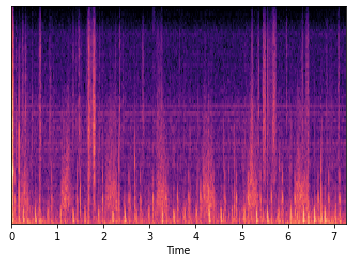

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[0][0][5][3][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)

In [150]:
model = get_toy3_1((100, 313, 1))

### Default 버전 확인

In [151]:
EPOCHS = 30
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절

history = model.fit(training_generator, validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/30
39/39 [==============================] - 2s 21ms/step - loss: 1.4124 - accuracy: 0.6802 - val_loss: 0.5945 - val_accuracy: 0.7431
Epoch 2/30
39/39 [==============================] - 1s 15ms/step - loss: 0.5737 - accuracy: 0.7713 - val_loss: 0.5913 - val_accuracy: 0.7431
Epoch 3/30
39/39 [==============================] - 1s 16ms/step - loss: 0.5649 - accuracy: 0.7636 - val_loss: 0.5999 - val_accuracy: 0.7517
Epoch 4/30
39/39 [==============================] - 1s 17ms/step - loss: 0.5326 - accuracy: 0.7842 - val_loss: 0.5912 - val_accuracy: 0.7465
Epoch 5/30
39/39 [==============================] - 1s 16ms/step - loss: 0.5648 - accuracy: 0.7723 - val_loss: 0.5705 - val_accuracy: 0.7535
Epoch 6/30
39/39 [==============================] - 1s 16ms/step - loss: 0.5391 - accuracy: 0.7895 - val_loss: 0.6167 - val_accuracy: 0.7569
Epoch 7/30
39/39 [==============================] - 1s 17ms/step - loss: 0.5282 - accuracy: 0.8022 - val_loss: 0.5237 - val_accuracy: 0.7899
Epoch 8/30
39

### Mixup 적용

In [152]:
model = get_toy3_1((100, 313, 1))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7
#          'lowpass': [11,12,13,14,15,16,17,18],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

EPOCHS = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절

training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)

history = model.fit_generator(generator=training_generator, validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/50
39/39 [==============================] - 2s 33ms/step - loss: 0.8824 - accuracy: 0.6778 - val_loss: 0.5825 - val_accuracy: 0.7448
Epoch 2/50
39/39 [==============================] - 1s 26ms/step - loss: 0.5569 - accuracy: 0.7783 - val_loss: 0.5805 - val_accuracy: 0.7483
Epoch 3/50
39/39 [==============================] - 1s 26ms/step - loss: 0.5780 - accuracy: 0.7641 - val_loss: 0.5515 - val_accuracy: 0.7674
Epoch 4/50
39/39 [==============================] - 1s 28ms/step - loss: 0.5240 - accuracy: 0.8091 - val_loss: 0.5906 - val_accuracy: 0.7604
Epoch 5/50
39/39 [==============================] - 1s 27ms/step - loss: 0.5558 - accuracy: 0.7916 - val_loss: 0.5255 - val_accuracy: 0.7934
Epoch 6/50
39/39 [==============================] - 1s 27ms/step - loss: 0.5160 - accuracy: 0.8151 - val_loss: 0.5230 - val_accuracy: 0.7969
Epoch 7/50
39/39 [==============================] - 1s 27ms/step - loss: 0.5190 - accuracy: 0.8053 - val_loss: 0.4923 - val_accuracy: 0.8056
Epoch 8/50
39

### mixup + LP 

In [153]:
model = get_toy3_1((100, 313, 1))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

EPOCHS = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절
training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)
history = model.fit(training_generator, validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/50
39/39 [==============================] - 2s 31ms/step - loss: 0.7554 - accuracy: 0.7626 - val_loss: 0.6135 - val_accuracy: 0.7431
Epoch 2/50
39/39 [==============================] - 1s 28ms/step - loss: 0.5935 - accuracy: 0.7728 - val_loss: 0.6042 - val_accuracy: 0.7431
Epoch 3/50
39/39 [==============================] - 1s 27ms/step - loss: 0.5827 - accuracy: 0.7636 - val_loss: 0.6083 - val_accuracy: 0.7413
Epoch 4/50
39/39 [==============================] - 1s 27ms/step - loss: 0.5838 - accuracy: 0.7695 - val_loss: 0.5979 - val_accuracy: 0.7483
Epoch 5/50
39/39 [==============================] - 1s 27ms/step - loss: 0.6008 - accuracy: 0.7424 - val_loss: 0.5941 - val_accuracy: 0.7448
Epoch 6/50
39/39 [==============================] - 1s 25ms/step - loss: 0.5751 - accuracy: 0.7758 - val_loss: 0.5964 - val_accuracy: 0.7431
Epoch 7/50
39/39 [==============================] - 1s 30ms/step - loss: 0.5862 - accuracy: 0.7717 - val_loss: 0.5935 - val_accuracy: 0.7500
Epoch 8/50
39

### mixup + HP

In [154]:
model = get_toy3_1((100, 313, 1))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
#          'lowpass': [11,12,13,14,15,16,17,18],
          'highpass': [.5, [78,79,80,81,82,83,84,85]]
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

EPOCHS = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절
training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)
history = model.fit(training_generator, validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/50
39/39 [==============================] - 2s 35ms/step - loss: 0.8573 - accuracy: 0.6439 - val_loss: 0.5862 - val_accuracy: 0.7413
Epoch 2/50
39/39 [==============================] - 1s 31ms/step - loss: 0.5834 - accuracy: 0.7722 - val_loss: 0.5776 - val_accuracy: 0.7569
Epoch 3/50
39/39 [==============================] - 1s 27ms/step - loss: 0.5797 - accuracy: 0.7779 - val_loss: 0.5445 - val_accuracy: 0.7934
Epoch 4/50
39/39 [==============================] - 1s 30ms/step - loss: 0.5640 - accuracy: 0.7830 - val_loss: 0.5781 - val_accuracy: 0.7517
Epoch 5/50
39/39 [==============================] - 1s 28ms/step - loss: 0.5449 - accuracy: 0.7970 - val_loss: 0.5188 - val_accuracy: 0.8021
Epoch 6/50
39/39 [==============================] - 1s 29ms/step - loss: 0.5270 - accuracy: 0.8165 - val_loss: 0.5120 - val_accuracy: 0.8021
Epoch 7/50
39/39 [==============================] - 1s 28ms/step - loss: 0.4727 - accuracy: 0.8457 - val_loss: 0.5065 - val_accuracy: 0.8108
Epoch 8/50
39

### mixup + RP

In [155]:
model = get_toy3_1((100, 313, 1))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
#          'lowpass': [11,12,13,14,15,16,17,18],
#          'highpass': [78,79,80,81,82,83,84,85]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

EPOCHS = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절
training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)
history = model.fit(training_generator, validation_data=validation_generator,

                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/50
39/39 [==============================] - 2s 35ms/step - loss: 0.7687 - accuracy: 0.7514 - val_loss: 0.6112 - val_accuracy: 0.7431
Epoch 2/50
39/39 [==============================] - 1s 33ms/step - loss: 0.5976 - accuracy: 0.7643 - val_loss: 0.6090 - val_accuracy: 0.7431
Epoch 3/50
39/39 [==============================] - 1s 33ms/step - loss: 0.5764 - accuracy: 0.7606 - val_loss: 0.6099 - val_accuracy: 0.7500
Epoch 4/50
39/39 [==============================] - 1s 34ms/step - loss: 0.5883 - accuracy: 0.7642 - val_loss: 0.5805 - val_accuracy: 0.7569
Epoch 5/50
39/39 [==============================] - 1s 33ms/step - loss: 0.5764 - accuracy: 0.7683 - val_loss: 0.5761 - val_accuracy: 0.7622
Epoch 6/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5658 - accuracy: 0.7712 - val_loss: 0.5623 - val_accuracy: 0.7743
Epoch 7/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5647 - accuracy: 0.7792 - val_loss: 0.5602 - val_accuracy: 0.7760
Epoch 8/50
39

### mixup + RP + HP, epoch 도 늘려서

In [157]:
model = get_toy3_1((100, 313, 1))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
#          'lowpass': [11,12,13,14,15,16,17,18],
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

EPOCHS = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절
training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)
history = model.fit(training_generator, validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/100
39/39 [==============================] - 2s 37ms/step - loss: 1.0795 - accuracy: 0.6798 - val_loss: 0.6022 - val_accuracy: 0.7431
Epoch 2/100
39/39 [==============================] - 1s 29ms/step - loss: 0.5910 - accuracy: 0.7594 - val_loss: 0.6319 - val_accuracy: 0.7517
Epoch 3/100
39/39 [==============================] - 1s 30ms/step - loss: 0.5868 - accuracy: 0.7757 - val_loss: 0.6123 - val_accuracy: 0.7569
Epoch 4/100
39/39 [==============================] - 1s 31ms/step - loss: 0.5706 - accuracy: 0.7870 - val_loss: 0.5831 - val_accuracy: 0.7448
Epoch 5/100
39/39 [==============================] - 1s 33ms/step - loss: 0.5757 - accuracy: 0.7794 - val_loss: 0.6030 - val_accuracy: 0.7517
Epoch 6/100
39/39 [==============================] - 1s 29ms/step - loss: 0.5732 - accuracy: 0.7734 - val_loss: 0.5873 - val_accuracy: 0.7500
Epoch 7/100
39/39 [==============================] - 1s 34ms/step - loss: 0.5303 - accuracy: 0.7969 - val_loss: 0.5482 - val_accuracy: 0.7691
Epoch 

39/39 [==============================] - 1s 33ms/step - loss: 0.4535 - accuracy: 0.8614 - val_loss: 0.4266 - val_accuracy: 0.8420
Epoch 59/100
39/39 [==============================] - 1s 31ms/step - loss: 0.4533 - accuracy: 0.8405 - val_loss: 0.4204 - val_accuracy: 0.8420
Epoch 60/100
39/39 [==============================] - 1s 33ms/step - loss: 0.4522 - accuracy: 0.8555 - val_loss: 0.4383 - val_accuracy: 0.8455
Epoch 61/100
39/39 [==============================] - 1s 34ms/step - loss: 0.4421 - accuracy: 0.8628 - val_loss: 0.4323 - val_accuracy: 0.8385
Epoch 62/100
39/39 [==============================] - 1s 34ms/step - loss: 0.4548 - accuracy: 0.8471 - val_loss: 0.4316 - val_accuracy: 0.8403
Epoch 63/100
39/39 [==============================] - 1s 34ms/step - loss: 0.4689 - accuracy: 0.8440 - val_loss: 0.4292 - val_accuracy: 0.8420
Epoch 64/100
39/39 [==============================] - 1s 31ms/step - loss: 0.4622 - accuracy: 0.8429 - val_loss: 0.4424 - val_accuracy: 0.8385
Epoch 65/100

### mixup + RP , epoch 도 늘려서, 외부변수 사용 안함

In [158]:
model = get_toy4_1((100, 313, 1))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
#          'lowpass': [11,12,13,14,15,16,17,18],
#          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': False
          #'device': device
}

EPOCHS = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS, lr_start=1e-3, lr_end=1e-5))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: 1, 1: 1., 2: 1} ## 클래스별 가중치는 나중에 조절
training_generator = DataGenerator([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1], **params)
validation_generator = DataGenerator([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1], **params_no_shuffle)
history = model.fit(training_generator, validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Epoch 1/100
39/39 [==============================] - 2s 34ms/step - loss: 1.5005 - accuracy: 0.6531 - val_loss: 0.6052 - val_accuracy: 0.7431
Epoch 2/100
39/39 [==============================] - 1s 31ms/step - loss: 0.5793 - accuracy: 0.7734 - val_loss: 0.5952 - val_accuracy: 0.7431
Epoch 3/100
39/39 [==============================] - 1s 33ms/step - loss: 0.5968 - accuracy: 0.7640 - val_loss: 0.6120 - val_accuracy: 0.7431
Epoch 4/100
39/39 [==============================] - 1s 32ms/step - loss: 0.5681 - accuracy: 0.7814 - val_loss: 0.6050 - val_accuracy: 0.7431
Epoch 5/100
39/39 [==============================] - 1s 31ms/step - loss: 0.5721 - accuracy: 0.7820 - val_loss: 0.5968 - val_accuracy: 0.7431
Epoch 6/100
39/39 [==============================] - 1s 35ms/step - loss: 0.5908 - accuracy: 0.7551 - val_loss: 0.6138 - val_accuracy: 0.7448
Epoch 7/100
39/39 [==============================] - 1s 30ms/step - loss: 0.5901 - accuracy: 0.7676 - val_loss: 0.5890 - val_accuracy: 0.7535
Epoch 

39/39 [==============================] - 1s 34ms/step - loss: 0.4661 - accuracy: 0.8444 - val_loss: 0.4470 - val_accuracy: 0.8333
Epoch 59/100
39/39 [==============================] - 1s 33ms/step - loss: 0.4600 - accuracy: 0.8348 - val_loss: 0.4436 - val_accuracy: 0.8212
Epoch 60/100
39/39 [==============================] - 1s 33ms/step - loss: 0.4546 - accuracy: 0.8480 - val_loss: 0.4370 - val_accuracy: 0.8316
Epoch 61/100
39/39 [==============================] - 1s 36ms/step - loss: 0.4515 - accuracy: 0.8487 - val_loss: 0.4335 - val_accuracy: 0.8229
Epoch 62/100
39/39 [==============================] - 1s 35ms/step - loss: 0.4472 - accuracy: 0.8504 - val_loss: 0.4415 - val_accuracy: 0.8229
Epoch 63/100
39/39 [==============================] - 1s 32ms/step - loss: 0.4634 - accuracy: 0.8459 - val_loss: 0.4339 - val_accuracy: 0.8333
Epoch 64/100
39/39 [==============================] - 1s 34ms/step - loss: 0.4599 - accuracy: 0.8679 - val_loss: 0.4409 - val_accuracy: 0.8368
Epoch 65/100

In [159]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

### 제일 잘 되었던 버전 epoch 늘려서 다시 한번..

In [160]:
model = get_toy4_1((100, 313, 1))
n_epoch = 150
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/150
40/40 [==============================] - 2s 47ms/step - loss: 0.7634 - accuracy: 0.7667 - val_loss: 0.5819 - val_accuracy: 0.7480
Epoch 2/150
40/40 [==============================] - 1s 38ms/step - loss: 0.5896 - accuracy: 0.7709 - val_loss: 0.5736 - val_accuracy: 0.7559
Epoch 3/150
40/40 [==============================] - 2s 39ms/step - loss: 0.5730 - accuracy: 0.7715 - val_loss: 0.6418 - val_accuracy: 0.7480
Epoch 4/150
40/40 [==============================] - 1s 37ms/step - loss: 0.5930 - accuracy: 0.7740 - val_loss: 0.5668 - val_accuracy: 0.7718
Epoch 5/150
40/40 [==============================] - 1s 35ms/step - loss: 0.5205 - accuracy: 0.8108 - val_loss: 0.5212 - val_accuracy: 0.7924
Epoch 6/150
40/40 [==============================] - 2s 43ms/step - loss: 0.5201 - accuracy: 0.8134 - val_loss: 0.5278 - val_accuracy: 0.7924
Epoch 7/150
40/40 [==============================] - 1s 37ms/step - loss: 0.5125 - accuracy: 0.8221 - val_loss: 0.5059 - val_accuracy: 0.7940
Epoch 

40/40 [==============================] - 2s 40ms/step - loss: 0.4260 - accuracy: 0.8727 - val_loss: 0.4160 - val_accuracy: 0.8304
Epoch 59/150
40/40 [==============================] - 1s 37ms/step - loss: 0.4124 - accuracy: 0.8775 - val_loss: 0.4471 - val_accuracy: 0.8320
Epoch 60/150
40/40 [==============================] - 2s 41ms/step - loss: 0.4343 - accuracy: 0.8493 - val_loss: 0.4266 - val_accuracy: 0.8479
Epoch 61/150
40/40 [==============================] - 1s 36ms/step - loss: 0.4045 - accuracy: 0.8694 - val_loss: 0.4138 - val_accuracy: 0.8399
Epoch 62/150
40/40 [==============================] - 1s 34ms/step - loss: 0.4334 - accuracy: 0.8695 - val_loss: 0.4267 - val_accuracy: 0.8494
Epoch 63/150
40/40 [==============================] - 1s 36ms/step - loss: 0.3976 - accuracy: 0.8836 - val_loss: 0.4800 - val_accuracy: 0.8399
Epoch 64/150
40/40 [==============================] - 1s 37ms/step - loss: 0.4241 - accuracy: 0.8702 - val_loss: 0.4183 - val_accuracy: 0.8447
Epoch 65/150

40/40 [==============================] - 1s 38ms/step - loss: 0.3670 - accuracy: 0.9144 - val_loss: 0.4866 - val_accuracy: 0.8241
Epoch 116/150
40/40 [==============================] - 1s 37ms/step - loss: 0.3642 - accuracy: 0.9027 - val_loss: 0.4983 - val_accuracy: 0.8352
Epoch 117/150
40/40 [==============================] - 2s 40ms/step - loss: 0.3880 - accuracy: 0.8879 - val_loss: 0.4885 - val_accuracy: 0.8241
Epoch 118/150
40/40 [==============================] - 1s 36ms/step - loss: 0.3765 - accuracy: 0.8981 - val_loss: 0.4894 - val_accuracy: 0.8257
Epoch 119/150
40/40 [==============================] - 2s 39ms/step - loss: 0.3739 - accuracy: 0.8967 - val_loss: 0.4913 - val_accuracy: 0.8273
Epoch 120/150
40/40 [==============================] - 2s 40ms/step - loss: 0.3717 - accuracy: 0.8921 - val_loss: 0.4955 - val_accuracy: 0.8288
Epoch 121/150
40/40 [==============================] - 2s 42ms/step - loss: 0.3758 - accuracy: 0.9044 - val_loss: 0.4956 - val_accuracy: 0.8336
Epoch 

In [162]:
model = get_toy4_1((100, 313, 1))
n_epoch = 150
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/150
40/40 [==============================] - 3s 46ms/step - loss: 1.4647 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7448
Epoch 2/150
40/40 [==============================] - 2s 41ms/step - loss: 0.5932 - accuracy: 0.7585 - val_loss: 0.5827 - val_accuracy: 0.7528
Epoch 3/150
40/40 [==============================] - 2s 40ms/step - loss: 0.5680 - accuracy: 0.7790 - val_loss: 0.5670 - val_accuracy: 0.7607
Epoch 4/150
40/40 [==============================] - 2s 41ms/step - loss: 0.5752 - accuracy: 0.7669 - val_loss: 0.5647 - val_accuracy: 0.7528
Epoch 5/150
40/40 [==============================] - 2s 44ms/step - loss: 0.5734 - accuracy: 0.7751 - val_loss: 0.5838 - val_accuracy: 0.7639
Epoch 6/150
40/40 [==============================] - 2s 41ms/step - loss: 0.5623 - accuracy: 0.7848 - val_loss: 0.5539 - val_accuracy: 0.7623
Epoch 7/150
40/40 [==============================] - 2s 44ms/step - loss: 0.5462 - accuracy: 0.7931 - val_loss: 0.5107 - val_accuracy: 0.7924
Epoch 

40/40 [==============================] - 2s 45ms/step - loss: 0.4599 - accuracy: 0.8381 - val_loss: 0.4150 - val_accuracy: 0.8463
Epoch 59/150
40/40 [==============================] - 1s 38ms/step - loss: 0.4510 - accuracy: 0.8442 - val_loss: 0.4021 - val_accuracy: 0.8447
Epoch 60/150
40/40 [==============================] - 2s 42ms/step - loss: 0.4372 - accuracy: 0.8510 - val_loss: 0.4190 - val_accuracy: 0.8494
Epoch 61/150
40/40 [==============================] - 2s 44ms/step - loss: 0.4306 - accuracy: 0.8656 - val_loss: 0.4219 - val_accuracy: 0.8415
Epoch 62/150
40/40 [==============================] - 2s 39ms/step - loss: 0.4369 - accuracy: 0.8657 - val_loss: 0.4158 - val_accuracy: 0.8352
Epoch 63/150
40/40 [==============================] - 2s 39ms/step - loss: 0.4180 - accuracy: 0.8600 - val_loss: 0.4323 - val_accuracy: 0.8431
Epoch 64/150
40/40 [==============================] - 2s 39ms/step - loss: 0.4336 - accuracy: 0.8644 - val_loss: 0.4103 - val_accuracy: 0.8479
Epoch 65/150

40/40 [==============================] - 2s 43ms/step - loss: 0.4034 - accuracy: 0.8771 - val_loss: 0.4491 - val_accuracy: 0.8384
Epoch 116/150
40/40 [==============================] - 2s 38ms/step - loss: 0.3888 - accuracy: 0.8881 - val_loss: 0.4476 - val_accuracy: 0.8399
Epoch 117/150
40/40 [==============================] - 1s 38ms/step - loss: 0.3987 - accuracy: 0.8898 - val_loss: 0.4468 - val_accuracy: 0.8399
Epoch 118/150
40/40 [==============================] - 2s 40ms/step - loss: 0.3864 - accuracy: 0.8767 - val_loss: 0.4496 - val_accuracy: 0.8384
Epoch 119/150
40/40 [==============================] - 2s 47ms/step - loss: 0.3818 - accuracy: 0.8875 - val_loss: 0.4481 - val_accuracy: 0.8352
Epoch 120/150
40/40 [==============================] - 2s 41ms/step - loss: 0.3870 - accuracy: 0.8903 - val_loss: 0.4454 - val_accuracy: 0.8352
Epoch 121/150
40/40 [==============================] - 2s 45ms/step - loss: 0.3952 - accuracy: 0.8710 - val_loss: 0.4484 - val_accuracy: 0.8368
Epoch 

한번더

In [145]:
model = get_toy4_1((100, 313, 1))
n_epoch = 150
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/150
40/40 [==============================] - 3s 54ms/step - loss: 1.2012 - accuracy: 0.6814 - val_loss: 0.5937 - val_accuracy: 0.7448
Epoch 2/150
40/40 [==============================] - 2s 50ms/step - loss: 0.5783 - accuracy: 0.7601 - val_loss: 0.5864 - val_accuracy: 0.7448
Epoch 3/150
40/40 [==============================] - 2s 48ms/step - loss: 0.5845 - accuracy: 0.7623 - val_loss: 0.5826 - val_accuracy: 0.7448
Epoch 4/150
40/40 [==============================] - 2s 46ms/step - loss: 0.5692 - accuracy: 0.7922 - val_loss: 0.5831 - val_accuracy: 0.7528
Epoch 5/150
40/40 [==============================] - 2s 45ms/step - loss: 0.5689 - accuracy: 0.7813 - val_loss: 0.5923 - val_accuracy: 0.7496
Epoch 6/150
40/40 [==============================] - 2s 47ms/step - loss: 0.5650 - accuracy: 0.7852 - val_loss: 0.5783 - val_accuracy: 0.7417
Epoch 7/150
40/40 [==============================] - 2s 42ms/step - loss: 0.5631 - accuracy: 0.7741 - val_loss: 0.5679 - val_accuracy: 0.7544
Epoch 

40/40 [==============================] - 2s 42ms/step - loss: 0.4260 - accuracy: 0.8734 - val_loss: 0.4218 - val_accuracy: 0.8621
Epoch 116/150
40/40 [==============================] - 2s 40ms/step - loss: 0.4320 - accuracy: 0.8660 - val_loss: 0.4326 - val_accuracy: 0.8574
Epoch 117/150
40/40 [==============================] - 2s 43ms/step - loss: 0.4325 - accuracy: 0.8608 - val_loss: 0.4222 - val_accuracy: 0.8621
Epoch 118/150
40/40 [==============================] - 2s 47ms/step - loss: 0.4325 - accuracy: 0.8544 - val_loss: 0.4263 - val_accuracy: 0.8621
Epoch 119/150
40/40 [==============================] - 2s 44ms/step - loss: 0.4282 - accuracy: 0.8668 - val_loss: 0.4195 - val_accuracy: 0.8653
Epoch 120/150
40/40 [==============================] - 2s 43ms/step - loss: 0.4317 - accuracy: 0.8754 - val_loss: 0.4178 - val_accuracy: 0.8621
Epoch 121/150
40/40 [==============================] - 2s 45ms/step - loss: 0.4250 - accuracy: 0.8648 - val_loss: 0.4162 - val_accuracy: 0.8605
Epoch 

### outcome 모형 제일 잘 되었던거

In [164]:
model2 = get_toy4_2((100, 313, 1))
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model2.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 3s 56ms/step - loss: 0.9734 - accuracy: 0.5312 - val_loss: 0.6842 - val_accuracy: 0.5246
Epoch 2/100
40/40 [==============================] - 2s 46ms/step - loss: 0.6960 - accuracy: 0.5212 - val_loss: 0.6779 - val_accuracy: 0.4992
Epoch 3/100
40/40 [==============================] - 2s 49ms/step - loss: 0.6943 - accuracy: 0.5164 - val_loss: 0.6680 - val_accuracy: 0.5800
Epoch 4/100
40/40 [==============================] - 2s 49ms/step - loss: 0.6890 - accuracy: 0.5225 - val_loss: 0.6629 - val_accuracy: 0.6260
Epoch 5/100
40/40 [==============================] - 2s 49ms/step - loss: 0.6854 - accuracy: 0.5309 - val_loss: 0.6569 - val_accuracy: 0.6149
Epoch 6/100
40/40 [==============================] - 2s 49ms/step - loss: 0.6871 - accuracy: 0.5617 - val_loss: 0.6641 - val_accuracy: 0.6307
Epoch 7/100
40/40 [==============================] - 2s 51ms/step - loss: 0.6844 - accuracy: 0.5716 - val_loss: 0.6675 - val_accuracy: 0.4992
Epoch 

40/40 [==============================] - 2s 43ms/step - loss: 0.6152 - accuracy: 0.6589 - val_loss: 0.6416 - val_accuracy: 0.6292
Epoch 59/100
40/40 [==============================] - 2s 44ms/step - loss: 0.6156 - accuracy: 0.6784 - val_loss: 0.6498 - val_accuracy: 0.6197
Epoch 60/100
40/40 [==============================] - 2s 42ms/step - loss: 0.6091 - accuracy: 0.7007 - val_loss: 0.6391 - val_accuracy: 0.6165
Epoch 61/100
40/40 [==============================] - 2s 43ms/step - loss: 0.6134 - accuracy: 0.6711 - val_loss: 0.6475 - val_accuracy: 0.6133
Epoch 62/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6200 - accuracy: 0.6840 - val_loss: 0.6424 - val_accuracy: 0.6197
Epoch 63/100
40/40 [==============================] - 2s 47ms/step - loss: 0.6124 - accuracy: 0.6647 - val_loss: 0.6345 - val_accuracy: 0.6339
Epoch 64/100
40/40 [==============================] - 2s 45ms/step - loss: 0.6138 - accuracy: 0.6965 - val_loss: 0.6516 - val_accuracy: 0.6307
Epoch 65/100

In [236]:
model = get_toy4_1((100, 313, 1))
n_epoch = 50
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/50
40/40 [==============================] - 3s 55ms/step - loss: 0.8791 - accuracy: 0.6937 - val_loss: 0.5700 - val_accuracy: 0.7512
Epoch 2/50
40/40 [==============================] - 2s 44ms/step - loss: 0.5848 - accuracy: 0.7684 - val_loss: 0.5696 - val_accuracy: 0.7528
Epoch 3/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5642 - accuracy: 0.7825 - val_loss: 0.5587 - val_accuracy: 0.7607
Epoch 4/50
40/40 [==============================] - 2s 45ms/step - loss: 0.5890 - accuracy: 0.7611 - val_loss: 0.5808 - val_accuracy: 0.7544
Epoch 5/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5679 - accuracy: 0.7683 - val_loss: 0.5433 - val_accuracy: 0.7702
Epoch 6/50
40/40 [==============================] - 2s 46ms/step - loss: 0.5765 - accuracy: 0.7562 - val_loss: 0.5277 - val_accuracy: 0.7908
Epoch 7/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5308 - accuracy: 0.8149 - val_loss: 0.5213 - val_accuracy: 0.7861
Epoch 8/50
40

In [238]:
model.predict([x1])

array([[0.10323787, 0.00888153, 0.8878806 ],
       [0.07061263, 0.00730975, 0.92207754],
       [0.7936843 , 0.00618752, 0.20012818],
       [0.25291297, 0.01072393, 0.7363631 ],
       [0.39078912, 0.01430624, 0.5949046 ],
       [0.24533027, 0.01730259, 0.7373671 ],
       [0.08078819, 0.00725832, 0.9119535 ],
       [0.14211787, 0.01042944, 0.8474527 ],
       [0.07262971, 0.00487227, 0.92249805],
       [0.16452955, 0.00516573, 0.83030474]], dtype=float32)

In [239]:
y1

array([[0.7, 0.2, 0.1],
       [0.7, 0.2, 0.1],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ]])

In [ ]:
[features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']]

In [237]:
i = 10
x1 = [features_test[0]['age'][:i],features_test[0]['sex'][:i], features_test[0]['hw'][:i], 
                              features_test[0]['preg'][:i], features_test[0]['loc'][:i], features_test[0]['mel1'][:i]]
y1 = features_test[1][:i]

In [240]:
model2 = get_toy4_2((100, 313, 1))
n_epoch = 30
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model2.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/30
40/40 [==============================] - 2s 52ms/step - loss: 1.5080 - accuracy: 0.4954 - val_loss: 0.6864 - val_accuracy: 0.5800
Epoch 2/30
40/40 [==============================] - 2s 42ms/step - loss: 0.6918 - accuracy: 0.5239 - val_loss: 0.6824 - val_accuracy: 0.4992
Epoch 3/30
40/40 [==============================] - 2s 45ms/step - loss: 0.6922 - accuracy: 0.5211 - val_loss: 0.6650 - val_accuracy: 0.6181
Epoch 4/30
40/40 [==============================] - 2s 44ms/step - loss: 0.6846 - accuracy: 0.5545 - val_loss: 0.6727 - val_accuracy: 0.5959
Epoch 5/30
40/40 [==============================] - 2s 47ms/step - loss: 0.6890 - accuracy: 0.5206 - val_loss: 0.6669 - val_accuracy: 0.5864
Epoch 6/30
40/40 [==============================] - 2s 45ms/step - loss: 0.6841 - accuracy: 0.5653 - val_loss: 0.6669 - val_accuracy: 0.4976
Epoch 7/30
40/40 [==============================] - 2s 46ms/step - loss: 0.6846 - accuracy: 0.5296 - val_loss: 0.6718 - val_accuracy: 0.4992
Epoch 8/30
40

In [243]:
i = 10
x1 = [features_test[0]['age'][:i],features_test[0]['sex'][:i], features_test[0]['hw'][:i], 
                              features_test[0]['preg'][:i], features_test[0]['loc'][:i], features_test[0]['mel1'][:i]]
y1 = features_test[1][:i]
y2 = features_test[2][:i]

In [254]:
model2.predict([x1])

array([[0.5792437 , 0.42075628],
       [0.52317816, 0.4768219 ],
       [0.75449824, 0.24550171],
       [0.5982656 , 0.4017344 ],
       [0.6949363 , 0.3050637 ],
       [0.5601671 , 0.439833  ],
       [0.4841418 , 0.5158582 ],
       [0.49360055, 0.50639945],
       [0.37819847, 0.62180156],
       [0.47231275, 0.5276873 ]], dtype=float32)

In [244]:
y2

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [246]:
model_folder

'tmp_model3'

In [247]:
import pickle as pk
def save_challenge_model2(model_folder, model1, model2, m_name1, m_name2, mel_shape = (100, 313, 1)) :
    os.makedirs(model_folder, exist_ok=True)
    info_fnm = os.path.join(model_folder, 'desc.pk')
    filename1 = os.path.join(model_folder, m_name1 + '_model1.hdf5')
    filename2 = os.path.join(model_folder, m_name2 + '_model2.hdf5')
    model1.save(filename1)
    model2.save(filename2)
    d = {'model1': m_name1, 'model2': m_name2, 'mel_shape': mel_shape, 'model_fnm1': filename1, 'model_fnm2': filename2}    
    with open(info_fnm, 'wb') as f:
        pk.dump(d, f, pk.HIGHEST_PROTOCOL)
    return 1
    

In [248]:
model_folder

'tmp_model3'

In [249]:
# Save the model.
save_challenge_model2(model_folder, model, model2, m_name1 = 'toy1', m_name2 = 'toy2')

1

In [250]:
def load_challenge_model(model_folder, verbose):
    info_fnm = os.path.join(model_folder, 'desc.pk')
    with open(info_fnm, 'rb') as f:
        info_m = pk.load(f)
#    if info_m['model'] == 'toy' :
#        model = get_toy(info_m['mel_shape'])
#    filename = os.path.join(model_folder, info_m['model'] + '_model.hdf5')
#    model.load_weights(filename)
    return info_m

In [251]:
model_load = load_challenge_model(model_folder, verbose = 1) ### Teams: Implement this function!!!


In [252]:
model_load

{'model1': 'toy1',
 'model2': 'toy2',
 'mel_shape': (100, 313, 1),
 'model_fnm1': 'tmp_model3/toy1_model1.hdf5',
 'model_fnm2': 'tmp_model3/toy2_model2.hdf5'}

In [264]:
patient_data = load_patient_data(patient_files_test[0])
recordings = load_recordings(data_folder, patient_data)
data = patient_data

In [185]:
model_load

{'model1': 'toy1',
 'model2': 'toy2',
 'mel_shape': (100, 313, 1),
 'model_fnm1': 'tmp_model3/toy1_model1.hdf5',
 'model_fnm2': 'tmp_model3/toy2_model1.hdf5'}

In [223]:
def get_feature_one(patient_data, verbose = 0) :
    num_locations = get_num_locations(patient_data)
    recording_information = patient_data.split('\n')[1:num_locations+1]

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    features = dict()
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
    for j in range(num_locations) :
        entries = recording_information[j].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)

        # Extract melspec
        mel1 = feature_extract_melspec(filename)[0]
        features['mel1'].append(mel1)

        # Extract age_group
        age_group = get_age(patient_data)
        current_age_group = np.zeros(6, dtype=int)
        if age_group in age_classes:
            j = age_classes.index(age_group)
            current_age_group[j] = 1
        else :
            current_age_group[5] = 1
        features['age'].append(current_age_group)

        # Extract sex
        sex = get_sex(patient_data)
        sex_features = np.zeros(2, dtype=int)
        if compare_strings(sex, 'Female'):
            sex_features[0] = 1
        elif compare_strings(sex, 'Male'):
            sex_features[1] = 1
        features['sex'].append(sex_features)

        # Extract height and weight.
        height = get_height(patient_data)
        weight = get_weight(patient_data)
        ## simple impute
        if math.isnan(height) :
            height = 110.846
        if math.isnan(weight) :
            weight = 23.767

        features['hw'].append(np.array([height, weight]))

        # Extract pregnancy
        is_pregnant = get_pregnancy_status(patient_data)
        features['preg'].append(is_pregnant)

        # Extract location
        locations = entries[0]
        num_recording_locations = len(recording_locations)
        loc_features = np.zeros(num_recording_locations)
        if locations in recording_locations:
            j = recording_locations.index(locations)
            loc_features[j] = 1
        features['loc'].append(loc_features)
        
        
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
        
    if verbose :
        label = get_label(patient_data)
        print(label)
    return features

In [ ]:
def run_challenge_model(model, data, recordings, verbose):
    
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']
    
    if model['model1'] == 'toy1' :
        model1 = get_toy4_1(model['mel_shape'])
    if model['model2'] == 'toy2' :
        model2 = get_toy4_2(model['mel_shape'])
    model1.load_weights(model['model_fnm1'])
    model2.load_weights(model['model_fnm2'])
    
#    classes = model['classes']
    # Load features.
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i]/ 32768)[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])
#    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

    # Get classifier probabilities.
    idx1 = res1.argmax(axis=0)[0]
    prob1 = res1[idx1,]
    prob2 = res2.mean(axis = 0) ## simple rule for now
    idx = np.argmax(prob1)
    # Choose label with higher probability.
    labels = np.zeros(len(classes), dtype=np.int_)
    labels[idx] = 1
    
    # Choose label with highest probability.
    murmur_labels = np.zeros(len(murmur_classes), dtype=np.int_)
    idx = np.argmax(murmur_probabilities)
    murmur_labels[idx] = 1
    outcome_labels = np.zeros(len(outcome_classes), dtype=np.int_)
    idx = np.argmax(outcome_probabilities)
    outcome_labels[idx] = 1
    
    # Concatenate classes, labels, and probabilities.
    classes = murmur_classes + outcome_classes
    labels = np.concatenate((murmur_labels, outcome_labels))
    probabilities = np.concatenate((murmur_probabilities, outcome_probabilities))
    
    return classes, labels, probabilities

In [ ]:
model

In [334]:
model_load

{'model1': 'toy1',
 'model2': 'toy2',
 'mel_shape': (100, 313, 1),
 'model_fnm1': 'tmp_model3/toy1_model1.hdf5',
 'model_fnm2': 'tmp_model3/toy2_model2.hdf5'}

In [335]:
    if model_load['model1'] == 'toy1' :
        model1 = get_toy4_1(model_load['mel_shape'])
    if model_load['model2'] == 'toy2' :
        model2 = get_toy4_2(model_load['mel_shape'])
    model1.load_weights(model_load['model_fnm1'])
    model2.load_weights(model_load['model_fnm2'])


In [336]:
model1.predict([x1])

array([[0.10323787, 0.00888153, 0.8878806 ],
       [0.07061263, 0.00730975, 0.92207754],
       [0.7936843 , 0.00618752, 0.20012818],
       [0.25291297, 0.01072393, 0.7363631 ],
       [0.39078912, 0.01430624, 0.5949046 ],
       [0.24533027, 0.01730259, 0.7373671 ],
       [0.08078819, 0.00725832, 0.9119535 ],
       [0.14211787, 0.01042944, 0.8474527 ],
       [0.07262971, 0.00487227, 0.92249805],
       [0.16452955, 0.00516573, 0.83030474]], dtype=float32)

In [337]:
model.predict([x1])

array([[4.81548198e-02, 5.92364138e-03, 9.45921540e-01],
       [2.89292932e-02, 3.82438768e-03, 9.67246294e-01],
       [7.60646880e-01, 6.92307809e-03, 2.32430056e-01],
       [2.11439475e-01, 7.16196606e-03, 7.81398535e-01],
       [5.54579556e-01, 1.39352018e-02, 4.31485236e-01],
       [4.98487532e-01, 2.02339198e-02, 4.81278539e-01],
       [3.43212560e-02, 1.00164106e-02, 9.55662310e-01],
       [6.08711429e-02, 3.99808353e-03, 9.35130715e-01],
       [1.16645163e-02, 8.77144048e-04, 9.87458348e-01],
       [1.21748134e-01, 1.08497674e-02, 8.67402136e-01]], dtype=float32)

In [356]:
patient_data = load_patient_data(patient_files_test[1])
recordings = load_recordings(data_folder, patient_data)
data = patient_data

In [357]:
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i]/ 32768)[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])


In [358]:
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])


In [359]:
idx1 = res1.argmax(axis=0)[0]
res1[idx1,]

array([0.3907892 , 0.01430625, 0.59490454], dtype=float32)

In [360]:
res1

array([[0.3907892 , 0.01430625, 0.59490454],
       [0.2453303 , 0.01730259, 0.7373671 ]], dtype=float32)

In [353]:
idx1 = res1.argmax(axis=0)[0]
res1 = res1[idx1,]

In [345]:
res1

array([[0.10323787, 0.00888153, 0.8878806 ],
       [0.07061263, 0.00730975, 0.92207754],
       [0.7936843 , 0.00618752, 0.20012818],
       [0.25291297, 0.01072393, 0.7363631 ]], dtype=float32)

In [346]:
res2

array([[0.5792437 , 0.42075628],
       [0.52317816, 0.4768219 ],
       [0.75449824, 0.24550171],
       [0.5982656 , 0.4017344 ]], dtype=float32)

In [228]:
    if model_load['model1'] == 'toy1' :
        model1 = get_toy4_1(model_load['mel_shape'])
    if model_load['model2'] == 'toy2' :
        model2 = get_toy4_2(model_load['mel_shape'])
    model1.load_weights(model_load['model_fnm1'])
    model2.load_weights(model_load['model_fnm2'])
    
#    classes = model['classes']
    # Load features.
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Normal', 'Abnormal']
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i]/ 32768)[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])
#    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

    # Get classifier probabilities.
    prob1 = res1.mean(axis = 0) ## simple rule for now
    idx = np.argmax(prob1)
    # Choose label with higher probability.
    labels = np.zeros(len(classes), dtype=np.int_)
    labels[idx] = 1


NameError: name 'classes' is not defined

33151 4 4000
AV 33151_AV.hea 33151_AV.wav 33151_AV.tsv
PV 33151_PV.hea 33151_PV.wav 33151_PV.tsv
TV 33151_TV.hea 33151_TV.wav 33151_TV.tsv
MV 33151_MV.hea 33151_MV.wav 33151_MV.tsv
#Age: Child
#Sex: Female
#Height: 141.0
#Weight: 30.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan



In [270]:
i = 0
patient_data = load_patient_data(patient_files_test[i])
recordings = load_recordings(data_folder, patient_data)
data = patient_data

print(patient_data)
features = get_feature_one(data, verbose = 0)

features['mel1'] = []
for i in range(len(recordings)) :
    mel1 = feature_extract_melspec(recordings[i]/ 32768)[0]
    features['mel1'].append(mel1)

M, N = features['mel1'][0].shape
for i in range(len(features['mel1'])) :
    features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   

features['mel1'] = np.array(features['mel1'])
#    print(features)
# Impute missing data.
res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
print("present", "unknown", "absent")
print(res1)
print("normal", "abnormal")
print(res2)

33151 4 4000
AV 33151_AV.hea 33151_AV.wav 33151_AV.tsv
PV 33151_PV.hea 33151_PV.wav 33151_PV.tsv
TV 33151_TV.hea 33151_TV.wav 33151_TV.tsv
MV 33151_MV.hea 33151_MV.wav 33151_MV.tsv
#Age: Child
#Sex: Female
#Height: 141.0
#Weight: 30.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[5.1548695e-03 9.9482179e-01 2.3306386e-05]
 [6.6083339e-03 9.9336338e-01 2.8347404e-05]
 [6.9625448e-03 9.9301553e-01 2.1956183e-05]
 [4.8867404e-03 9.9509603e-01 1.7233682e-05]]
normal abnormal
[[1.0000000e+00 5.2495792e-11]
 [1.0000000e+00 1.4813510e-10]
 [1.0000000e+00 4.40

In [275]:
feature_extract_melspec

<function get_feature.feature_extract_melspec(fnm, samp_sec=20, sr=4000, pre_emphasis=0, hop_length=256, win_length=512, n_mels=100)>

In [277]:
recordings[i] / 32768

array([ 0.09716797,  0.00222778,  0.07580566, ..., -0.02130127,
       -0.0402832 ,  0.03762817])

In [279]:
for i in range(len(patient_files_test)) :
    patient_data = load_patient_data(patient_files_test[i])
    recordings = load_recordings(data_folder, patient_data)
    data = patient_data

    print(patient_data)
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
            # Extract melspec
            
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i] / 32768 )[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   

    features['mel1'] = np.array(features['mel1'])
    #    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    print("present", "unknown", "absent")
    print(res1)
    print("normal", "abnormal")
    print(res2)

33151 4 4000
AV 33151_AV.hea 33151_AV.wav 33151_AV.tsv
PV 33151_PV.hea 33151_PV.wav 33151_PV.tsv
TV 33151_TV.hea 33151_TV.wav 33151_TV.tsv
MV 33151_MV.hea 33151_MV.wav 33151_MV.tsv
#Age: Child
#Sex: Female
#Height: 141.0
#Weight: 30.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.10323787 0.00888153 0.8878806 ]
 [0.07061263 0.00730975 0.92207754]
 [0.7936843  0.00618752 0.20012818]
 [0.25291297 0.01072393 0.7363631 ]]
normal abnormal
[[0.5792437  0.42075628]
 [0.52317816 0.4768219 ]
 [0.75449824 0.24550171]
 [0.5982656  0.4017344 ]]
38337 2 4000
AV 3

present unknown absent
[[0.11101196 0.01220371 0.8767843 ]
 [0.02467407 0.00380529 0.97152066]
 [0.06247913 0.00394904 0.9335719 ]
 [0.10871127 0.01008906 0.8811997 ]]
normal abnormal
[[0.49026626 0.50973374]
 [0.36700127 0.6329987 ]
 [0.640298   0.35970196]
 [0.48581135 0.51418865]]
49691 4 4000
AV 49691_AV.hea 49691_AV.wav 49691_AV.tsv
PV 49691_PV.hea 49691_PV.wav 49691_PV.tsv
TV 49691_TV.hea 49691_TV.wav 49691_TV.tsv
MV 49691_MV.hea 49691_MV.wav 49691_MV.tsv
#Age: Child
#Sex: Male
#Height: 133.0
#Weight: 24.8
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: II/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

pre

present unknown absent
[[0.16476364 0.00461306 0.8306233 ]
 [0.07976075 0.0040677  0.91617155]
 [0.07445548 0.00436409 0.9211804 ]
 [0.04635347 0.00269772 0.9509488 ]]
normal abnormal
[[0.57627046 0.42372957]
 [0.53596854 0.4640314 ]
 [0.49517044 0.5048295 ]
 [0.37928823 0.62071174]]
50006 2 4000
AV 50006_AV.hea 50006_AV.wav 50006_AV.tsv
MV 50006_MV.hea 50006_MV.wav 50006_MV.tsv
#Age: Infant
#Sex: Male
#Height: nan
#Weight: 9.3
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[6.43685281e-01 8.67341529e-04 3.55447382e-01]
 [1.13430105e-01 5.53146144e-03 8.81038427e-01]]
norma

present unknown absent
[[0.10991748 0.00371634 0.8863662 ]
 [0.03704522 0.00259067 0.96036416]
 [0.06441192 0.00404732 0.9315407 ]
 [0.018781   0.00206817 0.9791508 ]]
normal abnormal
[[0.4150953  0.58490473]
 [0.47262406 0.52737594]
 [0.5187338  0.48126623]
 [0.42627877 0.57372123]]
50105 3 4000
PV 50105_PV.hea 50105_PV.wav 50105_PV.tsv
TV 50105_TV.hea 50105_TV.wav 50105_TV.tsv
MV 50105_MV.hea 50105_MV.wav 50105_MV.tsv
#Age: Child
#Sex: Female
#Height: 121.0
#Weight: 20.9
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.19962674 0.00627088 0.79410243]
 [0.1806004  0.00510

present unknown absent
[[0.24403538 0.00285558 0.7531091 ]
 [0.35007963 0.01033081 0.63958955]]
normal abnormal
[[0.6148538  0.38514623]
 [0.5041036  0.4958964 ]]
50218 4 4000
AV 50218_AV.hea 50218_AV.wav 50218_AV.tsv
PV 50218_PV.hea 50218_PV.wav 50218_PV.tsv
TV 50218_TV.hea 50218_TV.wav 50218_TV.tsv
MV 50218_MV.hea 50218_MV.wav 50218_MV.tsv
#Age: Child
#Sex: Female
#Height: 142.0
#Weight: 39.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: 68460

present unknown absent
[[1.48503140e-01 4.76507889e-03 8.46731782e-01]
 [1.21426269e-01 7.21840700e-03 8.71355295e-01]
 [7.25421356e-03 5.58136904e-04 9.9218

present unknown absent
[[0.19068438 0.00944205 0.79987353]
 [0.6808791  0.00486686 0.31425396]]
normal abnormal
[[0.52146685 0.47853315]
 [0.78438175 0.21561822]]
50342 2 4000
AV 50342_AV.hea 50342_AV.wav 50342_AV.tsv
MV 50342_MV.hea 50342_MV.wav 50342_MV.tsv
#Age: Child
#Sex: Male
#Height: 89.0
#Weight: 13.3
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.38426176 0.00519637 0.6105419 ]
 [0.37269807 0.00821608 0.61908585]]
normal abnormal
[[0.52876997 0.47123006]
 [0.61126053 0.38873944]]
50348 5 4000
AV 50348_AV_1.hea 50348_AV_1.wav 50348_AV_1.tsv
AV 50348_AV_2.hea 50

present unknown absent
[[0.46351612 0.00656422 0.5299197 ]
 [0.1344017  0.00872698 0.8568713 ]]
normal abnormal
[[0.58747876 0.41252124]
 [0.5039971  0.49600294]]
50644 2 4000
AV 50644_AV.hea 50644_AV.wav 50644_AV.tsv
MV 50644_MV.hea 50644_MV.wav 50644_MV.tsv
#Age: Child
#Sex: Male
#Height: 93.0
#Weight: 15.7
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[[0.09923365 0.0063824  0.89438397]
 [0.07323571 0.00273358 0.9240307 ]]
normal abnormal
[[0.44515222 0.5548478 ]
 [0.40959138 0.5904086 ]]
50656 5 4000
AV 50656_AV.hea 50656_AV.wav 50656_AV.tsv
PV 50656_PV.hea 50656_PV.wav

present unknown absent
[[0.61121804 0.01024706 0.37853488]
 [0.89915615 0.00164652 0.09919732]
 [0.83692986 0.00523509 0.15783508]
 [0.6446746  0.00760108 0.34772438]
 [0.89016277 0.00147899 0.10835821]]
normal abnormal
[[0.51080495 0.48919505]
 [0.9082266  0.09177338]
 [0.82014114 0.17985886]
 [0.7699294  0.23007059]
 [0.86446667 0.13553336]]
50737 3 4000
PV 50737_PV.hea 50737_PV.wav 50737_PV.tsv
TV 50737_TV.hea 50737_TV.wav 50737_TV.tsv
MV 50737_MV.hea 50737_MV.wav 50737_MV.tsv
#Age: nan
#Sex: Female
#Height: nan
#Weight: nan
#Pregnancy status: True
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

present unknown absent
[

present unknown absent
[[0.11823268 0.01909836 0.86266893]
 [0.01539879 0.00619746 0.9784038 ]]
normal abnormal
[[0.57492083 0.42507917]
 [0.54916394 0.450836  ]]
61117 4 4000
AV 61117_AV.hea 61117_AV.wav 61117_AV.tsv
PV 61117_PV.hea 61117_PV.wav 61117_PV.tsv
TV 61117_TV.hea 61117_TV.wav 61117_TV.tsv
MV 61117_MV.hea 61117_MV.wav 61117_MV.tsv
#Age: Child
#Sex: Female
#Height: 74.0
#Weight: 7.8
#Pregnancy status: False
#Murmur: Present
#Murmur locations: TV
#Most audible location: TV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[3.9667994e-01 1.5970916e-02 5.8734912e-01]
 [2.8634423e-01 1.3975689e-02 6.9968009e-01]
 [9.7831589e-01 5.66006

present unknown absent
[[0.11783122 0.00874752 0.8734213 ]
 [0.19101466 0.00910516 0.79988027]]
normal abnormal
[[0.53942114 0.4605789 ]
 [0.49399263 0.50600743]]
68436 4 4000
AV 68436_AV.hea 68436_AV.wav 68436_AV.tsv
PV 68436_PV.hea 68436_PV.wav 68436_PV.tsv
TV 68436_TV.hea 68436_TV.wav 68436_TV.tsv
MV 68436_MV.hea 68436_MV.wav 68436_MV.tsv
#Age: Child
#Sex: Female
#Height: 133.0
#Weight: 24.9
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.0566287  0.00374426 0.93962705]
 [0.181982   0.00437276 0.8136452 ]
 [0.06310205 0.00184422 0.9350537 ]
 [0.08276202 0.00209531 0.91

present unknown absent
[[0.46973062 0.01107118 0.5191982 ]
 [0.22118461 0.01406355 0.76475185]
 [0.28011706 0.0150051  0.70487785]]
normal abnormal
[[0.7095971  0.2904029 ]
 [0.7183329  0.28166714]
 [0.7658188  0.23418126]]
68952 4 4000
AV 68952_AV.hea 68952_AV.wav 68952_AV.tsv
PV 68952_PV.hea 68952_PV.wav 68952_PV.tsv
TV 68952_TV.hea 68952_TV.wav 68952_TV.tsv
MV 68952_MV.hea 68952_MV.wav 68952_MV.tsv
#Age: Child
#Sex: Female
#Height: 92.0
#Weight: 13.9
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 50727

present unknown absent
[[0.20146713 0.02212363 0.7764092 ]
 [0.10665196 0.01116017 0.88218784]


present unknown absent
[[0.94585836 0.00240247 0.05173913]
 [0.882506   0.00309923 0.1143947 ]
 [0.8852408  0.01550663 0.09925263]
 [0.95508176 0.00367334 0.04124494]]
normal abnormal
[[0.91933256 0.08066744]
 [0.89552116 0.10447887]
 [0.70280397 0.29719597]
 [0.7961782  0.20382178]]
74417 4 4000
AV 74417_AV.hea 74417_AV.wav 74417_AV.tsv
PV 74417_PV.hea 74417_PV.wav 74417_PV.tsv
TV 74417_TV.hea 74417_TV.wav 74417_TV.tsv
MV 74417_MV.hea 74417_MV.wav 74417_MV.tsv
#Age: Infant
#Sex: Male
#Height: 69.0
#Weight: 7.67
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.60951835 0

present unknown absent
[[0.0262537  0.00435468 0.9693916 ]
 [0.06153893 0.00264552 0.9358156 ]
 [0.16443475 0.01572935 0.81983596]
 [0.48471949 0.00896421 0.5063163 ]]
normal abnormal
[[0.47180074 0.52819926]
 [0.45921415 0.54078585]
 [0.4368405  0.5631595 ]
 [0.5675794  0.4324206 ]]
84760 3 4000
PV 84760_PV.hea 84760_PV.wav 84760_PV.tsv
TV 84760_TV.hea 84760_TV.wav 84760_TV.tsv
MV 84760_MV.hea 84760_MV.wav 84760_MV.tsv
#Age: Child
#Sex: Female
#Height: 78.0
#Weight: 11.9
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.11142682 0.00338794 0.8851852 ]
 [0.15307124 0.006027

present unknown absent
[[0.21701072 0.01441082 0.76857847]
 [0.15636043 0.01085009 0.8327894 ]
 [0.14980772 0.01226511 0.83792716]
 [0.1116807  0.00874126 0.87957805]]
normal abnormal
[[0.5823567  0.41764328]
 [0.55683106 0.4431689 ]
 [0.56896126 0.43103877]
 [0.58071846 0.4192815 ]]
84857 2 4000
AV 84857_AV.hea 84857_AV.wav 84857_AV.tsv
MV 84857_MV.hea 84857_MV.wav 84857_MV.tsv
#Age: Infant
#Sex: Male
#Height: 63.0
#Weight: 5.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV
#Most audible location: MV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.40094626 0.01413277 0.584921  ]
 [0.5187059  0.01183549 0.46945858

present unknown absent
[[0.1269606  0.00740683 0.8656326 ]
 [0.02862645 0.00259881 0.96877474]
 [0.14917056 0.00410422 0.84672517]
 [0.01663709 0.00205959 0.98130333]]
normal abnormal
[[0.52444744 0.47555253]
 [0.6012988  0.3987012 ]
 [0.6665697  0.33343032]
 [0.5514683  0.44853172]]
84931 4 4000
AV 84931_AV.hea 84931_AV.wav 84931_AV.tsv
PV 84931_PV.hea 84931_PV.wav 84931_PV.tsv
TV 84931_TV.hea 84931_TV.wav 84931_TV.tsv
MV 84931_MV.hea 84931_MV.wav 84931_MV.tsv
#Age: Child
#Sex: Female
#Height: 116.0
#Weight: 21.6
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.16532794

present unknown absent
[[0.03806891 0.00652672 0.95540434]
 [0.01594336 0.00374639 0.98031026]
 [0.02010225 0.00214155 0.97775614]
 [0.09652494 0.00947118 0.89400387]]
normal abnormal
[[0.5646     0.43539995]
 [0.50400686 0.49599308]
 [0.536519   0.463481  ]
 [0.5677885  0.43221155]]
85024 4 4000
AV 85024_AV.hea 85024_AV.wav 85024_AV.tsv
PV 85024_PV.hea 85024_PV.wav 85024_PV.tsv
TV 85024_TV.hea 85024_TV.wav 85024_TV.tsv
MV 85024_MV.hea 85024_MV.wav 85024_MV.tsv
#Age: Child
#Sex: Female
#Height: 128.0
#Weight: 37.0
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: II/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

prese

present unknown absent
[[0.3232273  0.01457992 0.6621928 ]
 [0.16773032 0.00558924 0.8266805 ]
 [0.51135284 0.00925135 0.47939587]
 [0.08653254 0.00889211 0.9045753 ]]
normal abnormal
[[0.470626   0.529374  ]
 [0.45967367 0.54032636]
 [0.4511533  0.5488467 ]
 [0.40675434 0.5932456 ]]
85121 4 4000
AV 85121_AV.hea 85121_AV.wav 85121_AV.tsv
PV 85121_PV.hea 85121_PV.wav 85121_PV.tsv
TV 85121_TV.hea 85121_TV.wav 85121_TV.tsv
MV 85121_MV.hea 85121_MV.wav 85121_MV.tsv
#Age: Adolescent
#Sex: Female
#Height: 161.0
#Weight: 43.7
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.11739

present unknown absent
[[0.15197253 0.00472603 0.8433015 ]]
normal abnormal
[[0.58596545 0.41403455]]
85162 4 4000
AV 85162_AV.hea 85162_AV.wav 85162_AV.tsv
PV 85162_PV.hea 85162_PV.wav 85162_PV.tsv
TV 85162_TV.hea 85162_TV.wav 85162_TV.tsv
MV 85162_MV.hea 85162_MV.wav 85162_MV.tsv
#Age: Child
#Sex: Female
#Height: 130.0
#Weight: 24.8
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.06102632 0.00698654 0.9319871 ]
 [0.03447561 0.00437315 0.96115124]
 [0.0585233  0.00491181 0.93656486]
 [0.03858225 0.00437171 0.95704603]]
normal abnormal
[[0.40648243 0.5935176 ]
 [0.46043

present unknown absent
[[0.20730822 0.00948346 0.7832084 ]]
normal abnormal
[[0.6712412  0.32875878]]
85247 4 4000
AV 85247_AV.hea 85247_AV.wav 85247_AV.tsv
PV 85247_PV.hea 85247_PV.wav 85247_PV.tsv
TV 85247_TV.hea 85247_TV.wav 85247_TV.tsv
MV 85247_MV.hea 85247_MV.wav 85247_MV.tsv
#Age: Child
#Sex: Male
#Height: 115.0
#Weight: 23.5
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.21716914 0.01484577 0.76798517]
 [0.29437307 0.00716893 0.698458  ]
 [0.04606245 0.00663683 0.9473007 ]
 [0.13005778 0.00837654 0.8615657 ]]
normal abnormal
[[0.49843007 0.5015699 ]
 [0.678126 

present unknown absent
[[0.05618191 0.00511084 0.93870723]
 [0.19625089 0.0115841  0.79216504]
 [0.14387381 0.00669875 0.8494274 ]
 [0.29727006 0.02035234 0.68237764]]
normal abnormal
[[0.42040482 0.5795952 ]
 [0.5227543  0.47724572]
 [0.46318972 0.5368102 ]
 [0.46478853 0.53521144]]
85339 1 4000
MV 85339_MV.hea 85339_MV.wav 85339_MV.tsv
#Age: Infant
#Sex: Female
#Height: nan
#Weight: nan
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

present unknown absent
[[0.3953989  0.01308688 0.5915143 ]]
normal abnormal
[[0.7535069 0.2464931]]


In [223]:
def get_feature_one(patient_data, verbose = 0) :
    num_locations = get_num_locations(patient_data)
    recording_information = patient_data.split('\n')[1:num_locations+1]

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    features = dict()
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
    for j in range(num_locations) :
        entries = recording_information[j].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)

        # Extract melspec
        mel1 = feature_extract_melspec(filename)[0]
        features['mel1'].append(mel1)

        # Extract age_group
        age_group = get_age(patient_data)
        current_age_group = np.zeros(6, dtype=int)
        if age_group in age_classes:
            j = age_classes.index(age_group)
            current_age_group[j] = 1
        else :
            current_age_group[5] = 1
        features['age'].append(current_age_group)

        # Extract sex
        sex = get_sex(patient_data)
        sex_features = np.zeros(2, dtype=int)
        if compare_strings(sex, 'Female'):
            sex_features[0] = 1
        elif compare_strings(sex, 'Male'):
            sex_features[1] = 1
        features['sex'].append(sex_features)

        # Extract height and weight.
        height = get_height(patient_data)
        weight = get_weight(patient_data)
        ## simple impute
        if math.isnan(height) :
            height = 110.846
        if math.isnan(weight) :
            weight = 23.767

        features['hw'].append(np.array([height, weight]))

        # Extract pregnancy
        is_pregnant = get_pregnancy_status(patient_data)
        features['preg'].append(is_pregnant)

        # Extract location
        locations = entries[0]
        num_recording_locations = len(recording_locations)
        loc_features = np.zeros(num_recording_locations)
        if locations in recording_locations:
            j = recording_locations.index(locations)
            loc_features[j] = 1
        features['loc'].append(loc_features)
        
        
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
        
    if verbose :
        label = get_label(patient_data)
        print(label)
    return features